In [7]:
## utils

import exiftool
import numpy as np

def get_metadata(im_path):
    with exiftool.ExifToolHelper() as et:
       metadata = et.get_metadata(im_path)
       return metadata[0]
        #print(metadata[0].get("EXIF:GPSLatitude"))

def position(self): 
        """get the WGS-84 latitude, longitude tuple as signed decimal degrees"""
        lat = self.get_item('EXIF:GPSLatitude')
        latref = self.get_item('EXIF:GPSLatitudeRef')
        if latref == 'S':
            lat *= -1.0
        lon = self.get_item('EXIF:GPSLongitude')
        lonref = self.get_item('EXIF:GPSLongitudeRef')
        if lonref == 'W':
            lon *= -1.0
        alt = self.get_item('EXIF:GPSAltitude')
        return lat, lon, alt

def get_gps_coordinates(metadata):

    latitude = metadata.get('EXIF:GPSLatitude')
    latref = metadata.get('EXIF:GPSLatitudeRef')
    if latref == 'S':
        latitude *= -1.0
    longitude = metadata.get('EXIF:GPSLongitude')
    lonref = metadata.get('EXIF:GPSLongitudeRef')
    if lonref == 'W':
        longitude *= -1.0

    #latitude = metadata.get("EXIF:GPSLatitude")
    #longitude = metadata.get("EXIF:GPSLongitude")
    return latitude, longitude

def get_image_resolution(metadata):
    image_width = metadata.get("EXIF:ExifImageWidth") or metadata.get( "EXIF:ImageWidth")
    image_heigth = metadata.get("EXIF:ExifImageHeight") or metadata.get( "EXIF:ImageHeight")

    return image_width, image_heigth

def calculate_gsd(metadata):
    relative_altitude_text = metadata["XMP:RelativeAltitude"]
    print("relative_altitude_text:", relative_altitude_text)
    signo, numero = (relative_altitude_text[0], relative_altitude_text[1:]) if relative_altitude_text[0] in '+-' else ("+", relative_altitude_text[0])
    altitude_drone = float(numero) if signo == '+' else -float(numero)
    altitude_drone = altitude_drone * 100 # cm/pixel
    #print("altitude_drone:", altitude_drone)
    image_width, image_heigth = get_image_resolution(metadata)

    fov_metadata = metadata.get('Composite:FOV')
    if  isinstance(fov_metadata, str):
    # Extraer el FOV angular (primer número)
        fov_metadata = fov_metadata.split()[0]
        fov_metadata = float(fov_metadata)
    
    fov = float(fov_metadata)

    #print("fov:", fov)
    fov_rad = np.radians(fov)
    rel_asp = image_width / image_heigth
    fov_h = 2 * np.arctan((rel_asp / (np.sqrt(rel_asp ** 2 + 1))) * np.tan(fov_rad / 2))
    fov_v = 2 * np.arctan((1 / (np.sqrt(rel_asp ** 2 + 1))) * np.tan(fov_rad / 2))

    GSD_horizontal = (2 * altitude_drone * np.tan(fov_h)/ 2) / image_width #  cm/pixel
    GSD_vertical = (2 * altitude_drone * np.tan(fov_v / 2)) / image_heigth 
    
    return GSD_horizontal, GSD_vertical

def get_drone_model(metadata):
    if metadata["EXIF:Make"] == "DJI":
        return metadata["EXIF:Model"]
    return None

folder_path = "./data/trees-avocado/m3m/campo2/images/"


im_path = folder_path + "DJI_20241128154239_0001_D.JPG"
metadata = get_metadata(im_path)
latitude, longitude = get_gps_coordinates(metadata)
image_width, image_heigth = get_image_resolution(metadata)
yaw_degree = metadata.get("XMP:GimbalYawDegree")
pitch_degree = metadata.get("XMP:GimbalPitchDegree")
roll_degree = metadata.get("XMP:GimbalRollDegree")

if not isinstance(yaw_degree, float):
    signo, yaw_degree = (yaw_degree[0], yaw_degree[1:]) if yaw_degree[0] in '+-' else ("+", yaw_degree[0])
    yaw_degree =  float(yaw_degree) if signo == '+' else -float(yaw_degree)

GSD_horizontal, GSD_vertical = calculate_gsd(metadata)

model_drone = get_drone_model(metadata)
#GSD = 0.78
print(f"Latitud: {latitude}, Longitud: {longitude}")
print(f"image_width: {image_width}, image_heigth: {image_heigth}")
print(f"GSD_horizontal: {GSD_horizontal}, GSD_vertical: {GSD_vertical}")
print(f"yaw_degree: {yaw_degree}")
print(f"model_drone: {model_drone}")

relative_altitude_text: +15.005
Latitud: -13.8818156944444, Longitud: -73.0349101944444
image_width: 5280, image_heigth: 3956
GSD_horizontal: 0.5332612662700895, GSD_vertical: 0.34114712682831744
yaw_degree: 139.5
model_drone: M3M


In [8]:
camera_features = {
    "M3M": {
        "bands_features": {
                "RGB": { 
                    "suffix": "_D",
                    "file": "jpg"
                },
                "GREEN": { 
                "suffix": "_MS_G",
                "file": "tif"
                },
                'RED': { 
                "suffix": "_MS_R",
                "file": "tif"
                } ,
                "NIR": { 
                "suffix": "_MS_NIR",
                "file": "tif"
                },
                'RED_EDGE': { 
                "suffix": "_MS_RE",
                "file": "tif"
                }}
    }
}

bands_features = camera_features[model_drone]["bands_features"]
bands_features

{'RGB': {'suffix': '_D', 'file': 'jpg'},
 'GREEN': {'suffix': '_MS_G', 'file': 'tif'},
 'RED': {'suffix': '_MS_R', 'file': 'tif'},
 'NIR': {'suffix': '_MS_NIR', 'file': 'tif'},
 'RED_EDGE': {'suffix': '_MS_RE', 'file': 'tif'}}

# Leer metadatos de imagenes

In [9]:
from glob import glob
import os
import pandas as pd
#dir_images = "./mavic3m/campo2/Viaje3-27-Nov/DJI_202411281538_002_acco2-campo2/DJI_202411281538_002_acco2-campo2"
#folder_path = "mavic3m/campo2/Viaje3-27-Nov/DJI_202411281538_002_acco2-campo2/"

tif_files = glob(f"{folder_path}/*.TIF")

jpg_files = glob(f"{folder_path}/*.JPG")


images_names = tif_files + jpg_files
print(f"{len(jpg_files)} imagenes encontradas")

im_basenames = ["_".join(os.path.basename(im_file).split("_")[:3]) for im_file in jpg_files]

latitudes = []
longitudes  = []
yaw_degrees  = []
pitch_degrees  = []
roll_degrees = []
images_w = []
images_h = []
images_GSDH = []
images_GSDV = [] 
datetimes = []

for im_name in im_basenames:
    ## solo usamos el RGB por ahora
    im_path = f"{folder_path}/{im_name}{bands_features['RGB']['suffix']}.JPG"
    metadata = get_metadata(im_path)
    latitude, longitude = get_gps_coordinates(metadata)
    print(f"Latitud: {latitude}, Longitud: {longitude}")
    image_width, image_height = get_image_resolution(metadata)
    yaw_degree = metadata.get("XMP:GimbalYawDegree")
    pitch_degree = metadata.get("XMP:GimbalPitchDegree")
    roll_degree = metadata.get("XMP:GimbalRollDegree")
    if not isinstance(yaw_degree, float):
        signo, yaw_degree = (yaw_degree[0], yaw_degree[1:]) if yaw_degree[0] in '+-' else ("+", yaw_degree[0])
        yaw_degree =  float(yaw_degree) if signo == '+' else -float(yaw_degree)

    GSD_horizontal, GSD_vertical = calculate_gsd(metadata)
    
    latitudes.append(latitude)
    longitudes.append(longitude)
    yaw_degrees.append(yaw_degree)
    pitch_degrees.append(pitch_degree)
    roll_degrees.append(roll_degree)
    images_w.append(image_width)
    images_h.append(image_height)
    images_GSDH.append(GSD_horizontal)
    images_GSDV.append(GSD_vertical)
    datetimes.append(metadata.get("EXIF:DateTimeOriginal"))

df_images_metadata =  pd.DataFrame({"basename": im_basenames,
                                    "latitude": latitudes,
                                    "longitude" : longitudes,
                                    "yaw_degree": yaw_degrees,
                                    "pitch_degree": pitch_degrees,
                                    "roll_degree": roll_degrees,
                                    "image_w": images_w,
                                    "image_h": images_h,
                                    "GSDH": images_GSDH,
                                    'GSDV': images_GSDV,
                                    "DateTimeOriginal": datetimes,
                                    })
df_images_metadata["Timestamp_ms"] = pd.to_datetime(df_images_metadata["DateTimeOriginal"], format="%Y:%m:%d %H:%M:%S").astype(int) // 10**6

def filter_oblique_images(df_images):
    return df_images[(df_images['pitch_degree'] < -89) & (df_images['pitch_degree'] > -91)]

df_images_filtered = filter_oblique_images(df_images_metadata)

df_images_filtered.to_csv("./df_images_metadata.csv", index= False)
df_images_filtered = df_images_filtered.sort_values(by="Timestamp_ms", ascending=True)
df_images_filtered.head(10)

50 imagenes encontradas
Latitud: -13.8818156944444, Longitud: -73.0349101944444
relative_altitude_text: +15.005
Latitud: -13.8817958611111, Longitud: -73.0349295833333
relative_altitude_text: +15.018
Latitud: -13.881773, Longitud: -73.0349504722222
relative_altitude_text: +15.002
Latitud: -13.8817495555556, Longitud: -73.0349722222222
relative_altitude_text: +15.025
Latitud: -13.8817254722222, Longitud: -73.0349935555556
relative_altitude_text: +15.023
Latitud: -13.8817017222222, Longitud: -73.0350146388889
relative_altitude_text: +15.025
Latitud: -13.8816789444444, Longitud: -73.0350340555556
relative_altitude_text: +14.967
Latitud: -13.8816561944444, Longitud: -73.0350548333333
relative_altitude_text: +14.979
Latitud: -13.8816329444444, Longitud: -73.0350764722222
relative_altitude_text: +14.995
Latitud: -13.8816101944444, Longitud: -73.0350968055556
relative_altitude_text: +15.014
Latitud: -13.88158775, Longitud: -73.0351160555556
relative_altitude_text: +14.979
Latitud: -13.8815637

basename   latitude  longitude  yaw_degree  pitch_degree  \
0  DJI_20241128154239_0001 -13.881816 -73.034910       139.5         -90.0   
1  DJI_20241128154241_0002 -13.881796 -73.034930       138.9         -90.0   
2  DJI_20241128154244_0003 -13.881773 -73.034950       138.9         -90.0   
3  DJI_20241128154246_0004 -13.881750 -73.034972       138.9         -90.0   
4  DJI_20241128154249_0005 -13.881725 -73.034994       139.0         -90.0   
5  DJI_20241128154252_0006 -13.881702 -73.035015       -41.0         -89.9   
6  DJI_20241128154254_0007 -13.881679 -73.035034       -41.0         -89.9   
7  DJI_20241128154256_0008 -13.881656 -73.035055       -41.1         -89.9   
8  DJI_20241128154259_0009 -13.881633 -73.035076       139.0         -90.0   
9  DJI_20241128154302_0010 -13.881610 -73.035097       138.9         -90.0   

  roll_degree  image_w  image_h      GSDH      GSDV     DateTimeOriginal  \
0     +180.00     5280     3956  0.533261  0.341147  2024:11:28 15:42:39   
1     +180.00     5280     3956  0.533723  0.341443  2024:11:28 15:42:41   
2     +180.00     5280     3956  0.533155  0.341079  2024:11:28 15:42:44   
3     +180.00     5280     3956  0.533972  0.341602  2024:11:28 15:42:46   
4     +180.00     5280     3956  0.533901  0.341556  2024:11:28 15:42:49   
5       +0.00     5280     3956  0.533972  0.341602  2024:11:28 15:42:52   
6       +0.00     5280     3956  0.531911  0.340283  2024:11:28 15:42:54   
7       +0.00     5280     3956  0.532337  0.340556  2024:11:28 15:42:56   
8     +180.00     5280     3956  0.532906  0.340920  2024:11:28 15:42:59   
9     +180.00     5280     3956  0.533581  0.341352  2024:11:28 15:43:02   

    Timestamp_ms  
0  1732808559000  
1  1732808561000  
2  1732808564000  
3  1732808566000  
4  1732808569000  
5  1732808572000  
6  1732808574000  
7  1732808576000  
8  1732808579000  
9  1732808582000

In [10]:
df_images_filtered.head(10)

basename   latitude  longitude  yaw_degree  pitch_degree  \
0  DJI_20241128154239_0001 -13.881816 -73.034910       139.5         -90.0   
1  DJI_20241128154241_0002 -13.881796 -73.034930       138.9         -90.0   
2  DJI_20241128154244_0003 -13.881773 -73.034950       138.9         -90.0   
3  DJI_20241128154246_0004 -13.881750 -73.034972       138.9         -90.0   
4  DJI_20241128154249_0005 -13.881725 -73.034994       139.0         -90.0   
5  DJI_20241128154252_0006 -13.881702 -73.035015       -41.0         -89.9   
6  DJI_20241128154254_0007 -13.881679 -73.035034       -41.0         -89.9   
7  DJI_20241128154256_0008 -13.881656 -73.035055       -41.1         -89.9   
8  DJI_20241128154259_0009 -13.881633 -73.035076       139.0         -90.0   
9  DJI_20241128154302_0010 -13.881610 -73.035097       138.9         -90.0   

  roll_degree  image_w  image_h      GSDH      GSDV     DateTimeOriginal  \
0     +180.00     5280     3956  0.533261  0.341147  2024:11:28 15:42:39   
1     +180.00     5280     3956  0.533723  0.341443  2024:11:28 15:42:41   
2     +180.00     5280     3956  0.533155  0.341079  2024:11:28 15:42:44   
3     +180.00     5280     3956  0.533972  0.341602  2024:11:28 15:42:46   
4     +180.00     5280     3956  0.533901  0.341556  2024:11:28 15:42:49   
5       +0.00     5280     3956  0.533972  0.341602  2024:11:28 15:42:52   
6       +0.00     5280     3956  0.531911  0.340283  2024:11:28 15:42:54   
7       +0.00     5280     3956  0.532337  0.340556  2024:11:28 15:42:56   
8     +180.00     5280     3956  0.532906  0.340920  2024:11:28 15:42:59   
9     +180.00     5280     3956  0.533581  0.341352  2024:11:28 15:43:02   

    Timestamp_ms  
0  1732808559000  
1  1732808561000  
2  1732808564000  
3  1732808566000  
4  1732808569000  
5  1732808572000  
6  1732808574000  
7  1732808576000  
8  1732808579000  
9  1732808582000

In [13]:
## Mostrar mapa imagenes

import plotly.express as px
import plotly.graph_objects as go
#longitudes, latitudes = zip(*images_coordinates)
mapbox_token = "pk.eyJ1IjoiYW50aG9ueW1nMSIsImEiOiJjbTNuajBzamwxZXMxMmtweDV3anZkcHRxIn0.1ZlgQwJcn4msckpzTNSSJg"


fig = px.scatter_mapbox(
    lat=df_images_filtered["latitude"],  # Latitud de ejemplo (San Francisco)
    lon=df_images_filtered["longitude"],  # Longitud de ejemplo (San Francisco)
    zoom=18,  # Nivel de zoom
    height=800,  # Altura del gráfico
    hover_name= df_images_filtered["basename"]
)

# Configurar el mapa con el estilo satelital
fig.update_layout(
    mapbox_style="satellite",  # Estilo de mapa satelital
    mapbox_accesstoken=mapbox_token  # Tu token de acceso Mapbox
)


# Mostrar el mapa
fig.show()

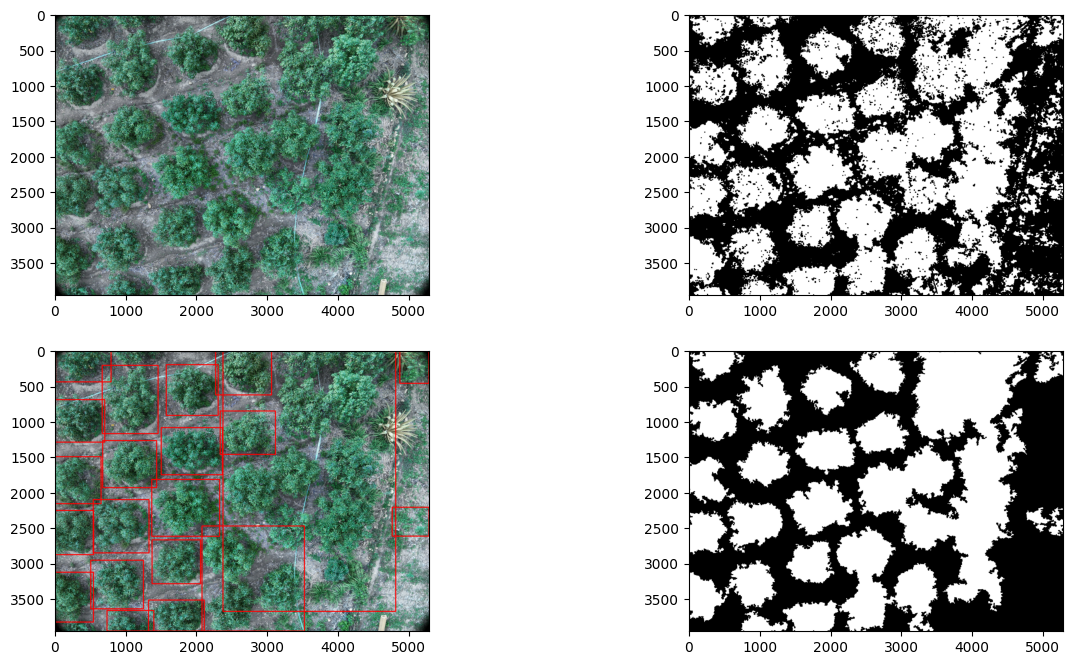

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detection_trees_pdi(image_uav, show = False):
    image_uav = cv2.GaussianBlur(image_uav, (5,5), 0)
    im_lab = cv2.cvtColor(image_uav, cv2.COLOR_BGR2HSV)

    
    rango_min = np.array([35, 90, 0])
    rango_max = np.array([70, 255, 255])

    #rango_min = np.array([40, 60, 20])
    #rango_max = np.array([80, 255, 200])

    kernel = np.ones((5,5), np.uint8)

    mascara = cv2.inRange(im_lab, rango_min, rango_max)
    mascara = cv2.morphologyEx(mascara, cv2.MORPH_OPEN, kernel, iterations = 1)
    mascara = cv2.morphologyEx(mascara, cv2.MORPH_CLOSE, kernel, iterations= 3)
    #mascara = cv2.dilate(mascara, kernel , iterations = 1)
    #mascara = cv2.erode(mascara, kernel , iterations = 2)
    #mascara = cv2.dilate(mascara, kernel , iterations = 1)
    countorus, _  = cv2.findContours(mascara, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    final_contours = []
    bboxes = []
    masks = []
    im_bboxes = image_uav.copy()

    for cn in countorus:
        area_cn = cv2.contourArea(cn)
        if area_cn > 65000:
            final_contours.append(cn)
            x, y, w, h = cv2.boundingRect(cn)
            image_mask_tree = np.zeros_like(mascara, dtype= mascara.dtype)
            cv2.drawContours(image_mask_tree, [cn], -1, color = 255, thickness = cv2.FILLED)
            masks.append(image_mask_tree)
            bboxes.append([x,y,w,h])
            #print("area:", area_cn)
            cv2.rectangle(im_bboxes, (x,y), (x + w, y + h), (255,0,0), 14)

    if show:
        mascara_filtrada = np.zeros_like(mascara, np.uint8)
        cv2.drawContours(mascara_filtrada, final_contours, -1, color = 255, thickness = cv2.FILLED)
        fig, axis = plt.subplots(2,2 , figsize = (15,8))
        axis[0][0].imshow(image_uav)
        axis[0][1].imshow(mascara, cmap = 'gray')
        axis[1][0].imshow(im_bboxes)
        axis[1][1].imshow(mascara_filtrada, cmap = 'gray')

    return bboxes, masks

im_trees = cv2.imread(im_path)

bboxes, masks = detection_trees_pdi(im_trees, show = True)

mask_name:  DJI_20241128154442_0050_D
mask_path: ./data/trees-avocado/m3m/campo2/masks/DJI_20241128154442_0050_D_MASK.JPG
mask: (3956, 5280, 3)
Numero de contornos: 29


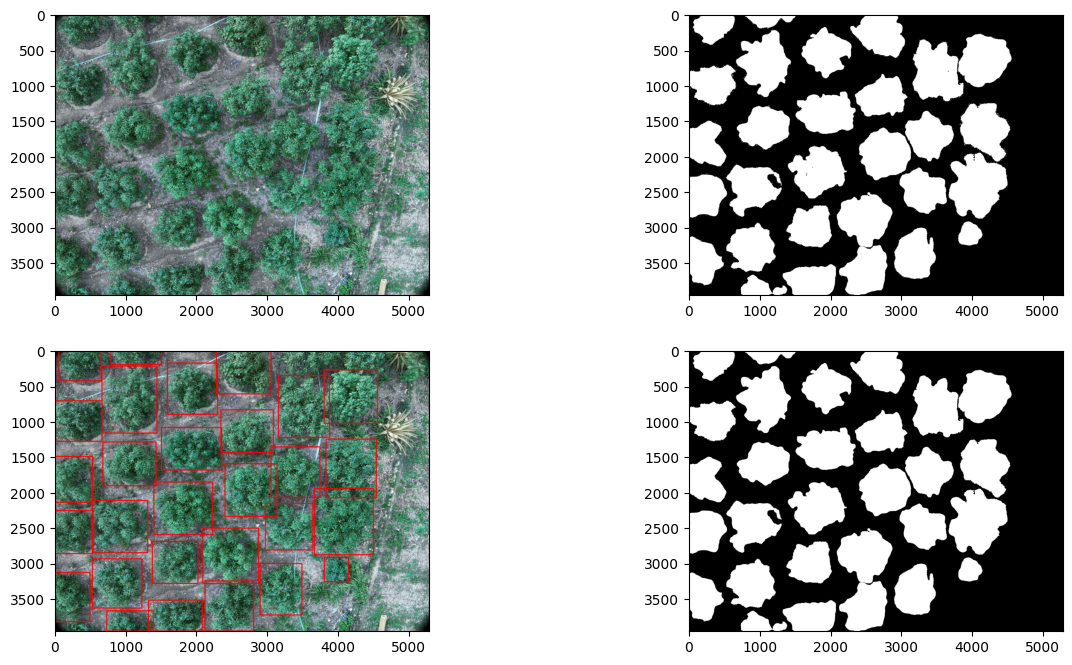

In [35]:
import os

def detection_trees_human(im_path, show = False):
    image_uav = cv2.imread(im_path)
    mask_name = os.path.basename(im_path)[:-4]
    print("mask_name: ", mask_name)
    mask_path = f"./data/trees-avocado/m3m/campo2/masks/{mask_name}_MASK.JPG"
    print("mask_path:", mask_path)

    image_uav = cv2.GaussianBlur(image_uav, (5,5), 0)
    mask = cv2.imread(mask_path)
    print("mask:", mask.shape)
    mask = mask != 0
    mask = mask.astype(np.uint8)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations = 1)
    #mask = cv2.erode(mask, kernel , iterations = 3)
    #mask = cv2.Canny(mask, 0, 500)
    countorus, _  = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    final_contours = []
    bboxes = []
    masks = []
    im_bboxes = image_uav.copy()

    for cn in countorus:
        area_cn = cv2.contourArea(cn)
        if area_cn > 65000:
            final_contours.append(cn)
            x, y, w, h = cv2.boundingRect(cn)
            bboxes.append([x,y,w,h])
            image_mask_tree = np.zeros_like(mask, dtype= mask.dtype)
            cv2.drawContours(image_mask_tree, [cn], -1, color = 255, thickness = cv2.FILLED)
            masks.append(image_mask_tree)
            #print("area:", area_cn)
            cv2.rectangle(im_bboxes, (x,y), (x + w, y + h), (255,0,0), 14)
    print("Numero de contornos:", len(final_contours))
    if show:
        mascara_filtrada = np.zeros_like(mask, np.uint8)
        cv2.drawContours(mascara_filtrada, final_contours, -1, color = 255, thickness = cv2.FILLED)
        fig, axis = plt.subplots(2,2 , figsize = (15,8))
        axis[0][0].imshow(image_uav)
        axis[0][1].imshow(mask, cmap = 'gray')
        axis[1][0].imshow(im_bboxes)
        axis[1][1].imshow(mascara_filtrada, cmap = 'gray')

    return bboxes, masks, mask


bboxes, masks, full_mask = detection_trees_human(im_path , show = True)

mask_name:  DJI_20241128154239_0001_D
mask_path: ./data/trees-avocado/m3m/campo2/masks/DJI_20241128154239_0001_D_MASK.JPG
mask: (3956, 5280, 3)
Numero de contornos: 17
mask_name:  DJI_20241128154241_0002_D
mask_path: ./data/trees-avocado/m3m/campo2/masks/DJI_20241128154241_0002_D_MASK.JPG
mask: (3956, 5280, 3)
Numero de contornos: 12
mask_name:  DJI_20241128154244_0003_D
mask_path: ./data/trees-avocado/m3m/campo2/masks/DJI_20241128154244_0003_D_MASK.JPG
mask: (3956, 5280, 3)
Numero de contornos: 14


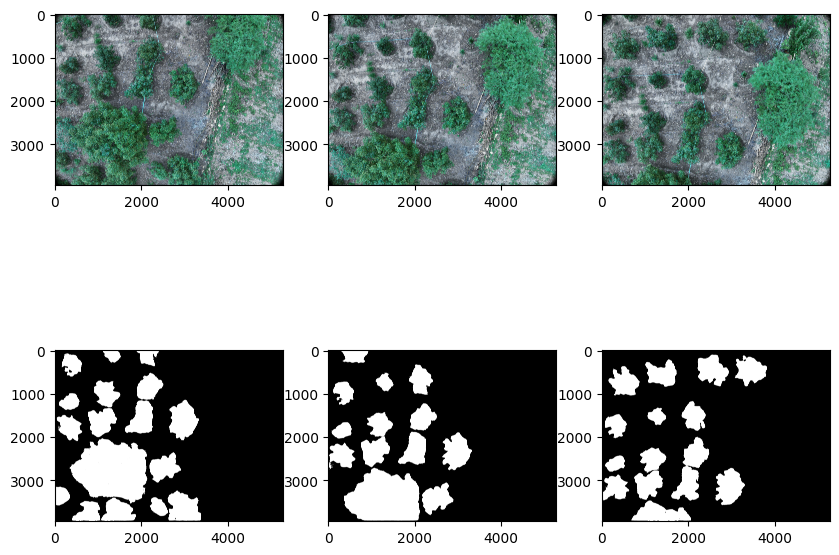

622655 matches encontrados
622655 matches encontrados


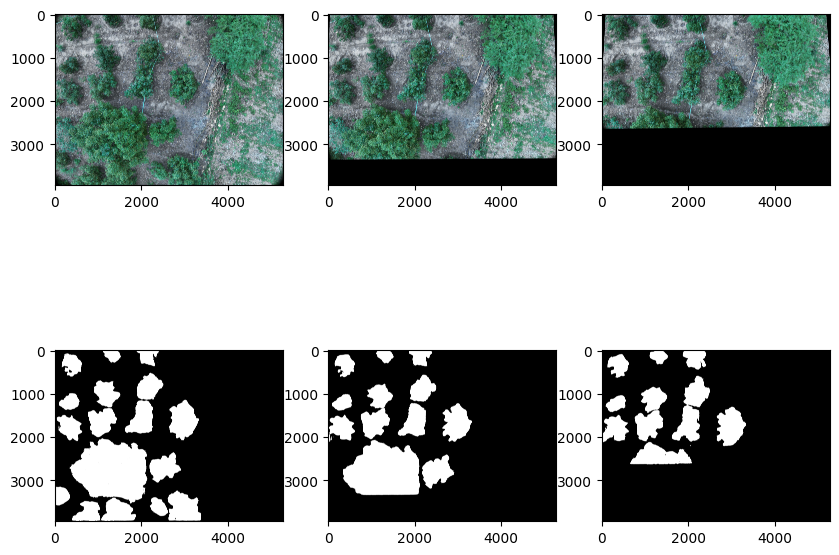

In [47]:
import cv2

def get_masks(mask):
    countorus, _  = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    bboxes = []
    masks = []
    coordinates = []
    for cn in countorus:
        area_cn = cv2.contourArea(cn)
        if area_cn > 65000:
            coordinates.append(cn)
            x, y, w, h = cv2.boundingRect(cn)
            bboxes.append([x,y,w,h])
            image_mask_tree = np.zeros_like(mask, dtype= mask.dtype)
            cv2.drawContours(image_mask_tree, [cn], -1, color = 255, thickness = cv2.FILLED)
            masks.append(image_mask_tree)
    return bboxes, masks, coordinates

def detect_keypoints(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

def match_features_flann(des1, des2):
    # Configuracion de parametros para el algoritmo de FLANN
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    
    # Inicializa objeto 
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Encontrar coinicidencias
    matches = flann.knnMatch(des1, des2, k=2) 

    print(f"{len(matches)} matches encontrados")

    #  Aplicar filtro por ratio
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    return good_matches
    
folder_path = "./data/trees-avocado/m3m/campo2/images/"

im_path_1 = folder_path + f"{df_images_filtered['basename'].iloc[0]}_D.JPG"
image_1 = cv2.imread(im_path_1)

im_path_2 = folder_path + f"{df_images_filtered['basename'].iloc[1]}_D.JPG"
image_2 = cv2.imread(im_path_2)

im_path_3 = folder_path + f"{df_images_filtered['basename'].iloc[2]}_D.JPG"
image_3 = cv2.imread(im_path_3)

_, _, full_mask_1 = detection_trees_human(im_path_1 , show = False)
_, _, full_mask_2 = detection_trees_human(im_path_2 , show = False)
_, _, full_mask_3 = detection_trees_human(im_path_3 , show = False)

_, axis = plt.subplots(2,3, figsize = (10,8))
axis[0,0].imshow(image_1)
axis[0,1].imshow(image_2)
axis[0,2].imshow(image_3)
axis[1,0].imshow(full_mask_1, cmap = "gray")
axis[1,1].imshow(full_mask_2, cmap = "gray")
axis[1,2].imshow(full_mask_3, cmap = "gray")
plt.show()

kps_1, descs_1 = detect_keypoints(image_1)
kps_2, descs_2 = detect_keypoints(image_2)
kps_3, descs_3 = detect_keypoints(image_3)

# Emparejar caracteristicas
matches = match_features_flann(descs_1, descs_2)

# Calcular Homografia
src_pts = np.float32([kps_2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
dst_pts = np.float32([kps_1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
warped_image2 = cv2.warpPerspective(image_2, H, (image_2.shape[1], image_2.shape[0]))
warped_full_mask_2 = cv2.warpPerspective(full_mask_2, H, (image_2.shape[1], image_2.shape[0]))

# Emparejar caracteristicas
matches = match_features_flann(descs_1, descs_3)

# Calcular Homografia
src_pts = np.float32([kps_3[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
dst_pts = np.float32([kps_1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
warped_image3 = cv2.warpPerspective(image_3, H, (image_3.shape[1], image_3.shape[0]))
warped_full_mask_3 = cv2.warpPerspective(full_mask_3, H, (image_3.shape[1], image_3.shape[0]))

_, axis = plt.subplots(2,3, figsize = (10,8))
axis[0,0].imshow(image_1)
axis[0,1].imshow(warped_image2)
axis[0,2].imshow(warped_image3)
axis[1,0].imshow(full_mask_1, cmap = "gray")
axis[1,1].imshow(warped_full_mask_2, cmap = "gray")
axis[1,2].imshow(warped_full_mask_3, cmap = "gray")
plt.show()

In [52]:
bboxes1, masks1, coordinates_1 =  get_masks(full_mask_1)
bboxes2, masks2, coordinates_2 =  get_masks(warped_full_mask_2)
bboxes3, masks3, coordinates_3 =  get_masks(warped_full_mask_3)

In [ ]:
def calculate_iou(mask1, mask2):
    interseccion = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    iou = interseccion / union if union > 0 else 0.0
    return iou

def match_segs(full_mask_ref, full_mask_tgt):
    bboxes_ref, masks_ref, coordinates_ref =  get_masks(full_mask_ref)
    bboxes_tgt, masks_tgt, coordinates_tgt =  get_masks(full_mask_tgt)
    for i in range(len(bboxes_ref)):
        bbox_ref = bboxes_ref[i]
        for j in range(len(bboxes_tgt)):
            bbox_tgt = bboxes_tgt[j]
            x, y, w, h = bbox
            c_x = x + w//2 
            c_y =  y + h//2
            if c_x > bbox_ref[0] and  c_x < bbox_ref[0] + bbox_ref[2] and c_y > bbox_ref[1] and  c_y < bbox_ref[1] + bbox_ref[3]:
                image_mask_ref = np.zeros_like(full_mask_ref, dtype= full_mask_ref.dtype)
                cv2.drawContours(image_mask_ref, [coordinates_ref[i]], -1, color = 255, thickness = cv2.FILLED)
                image_mask_tgt = np.zeros_like(full_mask_ref, dtype= full_mask_ref.dtype)
                cv2.drawContours(image_mask_tgt, [coordinates_tgt[i]], -1, color = 255, thickness = cv2.FILLED)
                iou = calculate_iou(image_mask_ref, image_mask_tgt)
                if iou > 0.90:
                    return [i,j]
def find_match(bbox_ref, coordinates_ref, bboxes, coordinates):
    for bbox in bboxes:
        x, y, w, h = bbox
        c_x = x + w//2 
        c_y =  y + h//2
        if c_x > bbox_ref[0] and  c_x < bbox_ref[0] + bbox_ref[2] and c_y > bbox_ref[1] and  c_y < bbox_ref[1] + bbox_ref[3]:
            image_mask_tree = np.zeros_like(mask, dtype= mask.dtype)
            cv2.drawContours(image_mask_tree, [cn], -1, color = 255, thickness = cv2.FILLED)
            #calculate_iou(mask1, mask2)
    
    return

for bbox, coordinates in zip(bboxes1, coordinates_1):
    # find match
    pass


In [54]:
bboxes3[0]

bboxes.append([x,y,w,h])

[649, 2128, 1434, 518]

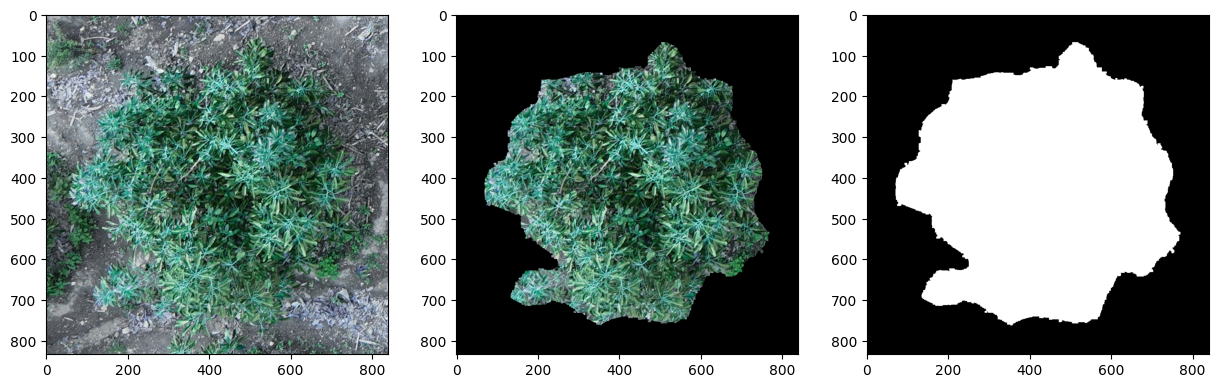

In [50]:
def crop_trees(image, bboxes, masks):
    # crop tress
    trees_crops = []
    seg_trees = []
    masks_crops = []
    centers = []
    for bbox, mask in zip(bboxes, masks):
        x, y, w, h = bbox
        n_w = int(w * 1.2)
        n_h = int(h * 1.2)
        x = max(x - (n_w - w) // 2 , 0)
        y = max(y - (n_h - h) // 2 , 0)
        im_frame = image[y:y + n_h, x: x + n_w, :]
        seg_tree = np.zeros_like(im_frame, dtype = im_frame.dtype)
        seg_tree = cv2.bitwise_and(image, image, mask = mask)
        trees_crops.append(im_frame)
        masks_crops.append(mask[y: y + n_h, x: x + n_w])
        seg_trees.append(seg_tree[y: y + n_h, x: x + n_w, :])

        centers.append([(2 * x + n_w) // 2,  (2 * y + n_h) // 2,])

    return trees_crops, seg_trees, masks_crops, centers

trees_crops, seg_trees, masks_trees, centers = crop_trees(im_trees, bboxes, masks)

idx = 5
fig, axis = plt.subplots(1,3, figsize = (15, 9))
im_tree = trees_crops[idx]
im_seg_tree = seg_trees[idx]
mask_tree = masks_trees[idx]
axis[0].imshow(im_tree)
axis[1].imshow(im_seg_tree)
axis[2].imshow(mask_tree, cmap = "gray")

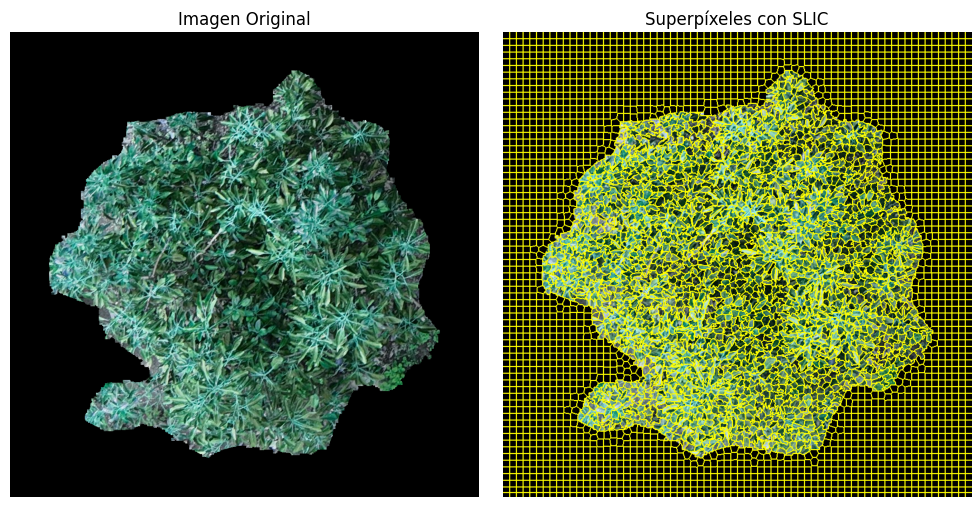

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, segmentation, color
from skimage.util import img_as_float
from skimage.segmentation import slic, mark_boundaries
from PIL import Image

# Aplicar SLIC
n_segments = 5000  # Número de superpíxeles
compactness = 20   # Parámetro de compactación
segments = slic(im_seg_tree, n_segments=n_segments, compactness=compactness, start_label=1)

slic_boundaries = mark_boundaries(im_seg_tree, segments)
boundaries = np.array((slic_boundaries * 255.0).astype(np.uint8))

im_boundaries = Image.fromarray(boundaries)
im_boundaries.save("leaf_slic_boundaries.jpg")

# Mostrar la imagen segmentada
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Imagen original
ax[0].imshow(im_seg_tree)
ax[0].set_title("Imagen Original")
ax[0].axis("off")

# Imagen con bordes de superpíxeles
ax[1].imshow(boundaries)
ax[1].set_title("Superpíxeles con SLIC")
ax[1].axis("off")

plt.tight_layout()
plt.show()

In [49]:
segments.shape

(834, 840)

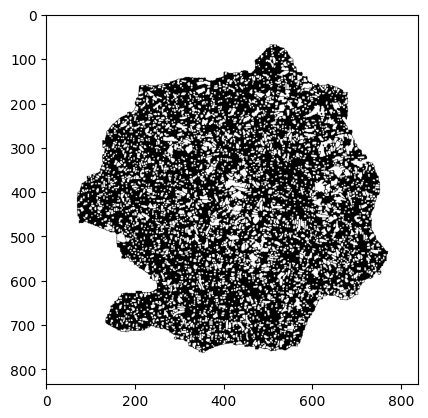

In [41]:
# Convertir a escala de grises
imagen_gris = cv2.cvtColor(im_seg_tree, cv2.COLOR_BGR2GRAY)

# Aplicar un desenfoque para reducir el ruido (opcional)
#imagen_desenfocada = cv2.GaussianBlur(imagen_gris, (5, 5), 0)

# Detectar bordes usando Canny
bordes = cv2.Canny(imagen_gris, threshold1=50, threshold2=200)

# Opcional: Cerrar áreas abiertas en la silueta
kernel = np.ones((3, 3), np.uint8)

bordes_refinados = cv2.morphologyEx(bordes, cv2.MORPH_CLOSE, kernel, iterations=1)
# Opcional: Invertir la imagen para que las siluetas sean blancas
bordes_invertidos = cv2.bitwise_not(bordes_refinados)

plt.imshow(bordes_invertidos, cmap="gray")

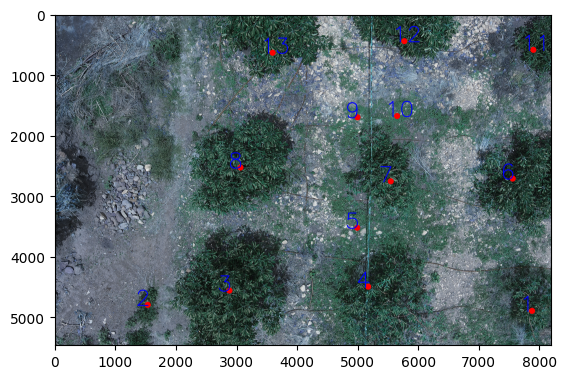

In [386]:
im_center_rot = im_trees.copy()

for i, c in enumerate(centers):
    cv2.circle(im_center_rot, c, radius = 50, color = (255, 0, 0), thickness = -1)
    cv2.putText(im_center_rot, str(i + 1), (c [0] - 200, c[1] + 10), cv2.FONT_HERSHEY_SIMPLEX, 12, (0,0,255), 15 )

plt.imshow(im_center_rot)

In [387]:
def calculate_gps_for_pixel(pixel_coord ,gps_image, gsd_horizontal, gsd_vertical, resolution, yaw_degree):
    latitud_image, longitude_image = gps_image
    height_image, width_image = resolution
    pixel_x, pixel_y = pixel_coord
    #print("pixel_coord:", pixel_coord)
    degree_rad = np.radians(yaw_degree)
    #print("desp pix:", "x:", pixel_x - width_image / 2, "y:", pixel_x - height_image / 2)
    ## Calculate desplazamiento en centimetros de pixel
    desp_x = (pixel_x - width_image / 2) * gsd_horizontal / 100
    desp_y = (pixel_y - height_image / 2) * gsd_vertical / 100

    #print("desp meters:", "x:", desp_x, "y:", desp_y)

    # ajustar desplazamiento segun angulo yaw
    desp_lat = (-desp_y * np.cos(degree_rad) - desp_x * np.sin(degree_rad)) / 111320
    #desp_long = (desp_x * np.cos(degree_rad) - desp_y * np.sin(degree_rad)) / (111320 * np.cos(np.radians(latitud_image)))
    desp_long = (desp_x * np.cos(degree_rad) - desp_y * np.sin(degree_rad)) / (111320 * np.cos(np.radians(latitud_image)))

    #print("desp gps:", "desp_lat:", desp_lat, "desp_long:", desp_long)
    # nuevas coordenadas
    latitud_pixel = latitud_image + desp_lat
    longitude_pixel = longitude_image + desp_long
    #print("latitud_pixel:", latitud_pixel, ", longitude_pixel:", longitude_pixel)
    return latitud_pixel, longitude_pixel

#print("")
coordinates = [calculate_gps_for_pixel(c , (latitude, longitude), GSD_horizontal, GSD_vertical, (image_heigth, image_width), yaw_degree) 
               for c in centers[:]]

print("centro imagen:" , "w:",  image_width // 2, "h:" ,image_heigth // 2)
print("centro imagen:" , "lat:",  latitude, "log:" ,longitude)

centro imagen: w: 4096 h: 2730
centro imagen: lat: -13.7881023888889 log: -72.95065025


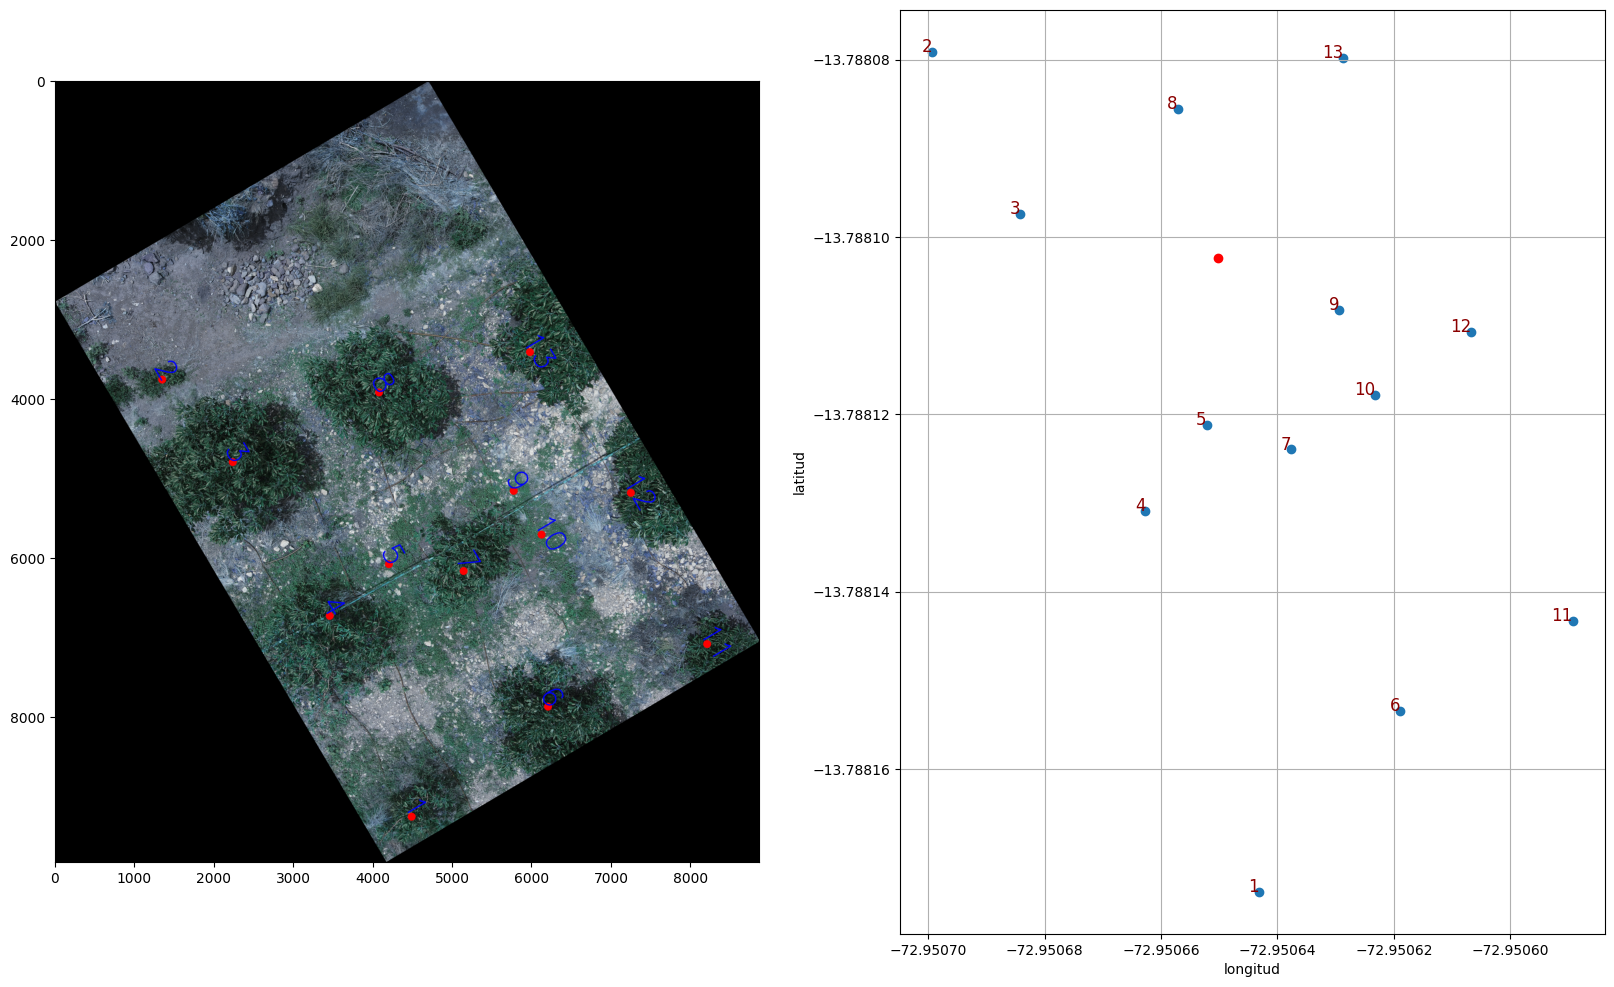

In [388]:
import matplotlib.pyplot as plt
## IMAGE ROTADA SEGUN PERSPECTIVA DEL DRONE CON EL NORTE
from PIL import Image

img = Image.fromarray(im_center_rot)
roteted_img = img.rotate(-yaw_degree, expand=True)
#roteted_img

fig, axis = plt.subplots(1, 2, figsize=(20,12))

latitudes, longitudes = zip(*coordinates[:])

axis[0].imshow(roteted_img)
axis[1].scatter(longitudes , latitudes)
for i, (x, y) in enumerate(zip(longitudes, latitudes)):
    axis[1].text(x, y, str(i + 1), fontsize = 12, ha = "right", color = "darkred")
axis[1].scatter(longitude, latitude, color = "red")
axis[1].set_xlabel("longitud")
axis[1].set_ylabel("latitud")
axis[1].ticklabel_format(useOffset=False, style='plain', axis='both')
axis[1].grid(True)

In [ ]:
from tqdm import tqdm
from glob import glob
import tempfile
import json
#images_path = glob("data/trees-avocado/images/*.JPG")

images_path = glob("data/campo1/vuelo2/RGB/*.JPG")

def save_img(image, path_save):
    img = Image.fromarray(image)
    img.save(path_save)

def save_json(data, path_save):
    with open(path_save, "w", encoding="utf-8") as json_file:
        json.dump(data, json_file, indent=4, ensure_ascii=False)

def extraction_trees(im_path):
    # Extracion de matadatos
    metadata = get_metadata(im_path)
    latitude, longitude = get_gps_coordinates(metadata)
    image_width, image_heigth = get_image_resolution(metadata)
    yaw_degree = metadata.get("XMP:GimbalYawDegree")
    
    if not isinstance(yaw_degree, float):
        signo, yaw_degree = (yaw_degree[0], yaw_degree[1:]) if yaw_degree[0] in '+-' else ("+", yaw_degree[0])
        yaw_degree =  float(yaw_degree) if signo == '+' else -float(yaw_degree)
    GSD_horizontal, GSD_vertical = calculate_gsd(metadata)
    
    # Segmentacion de Arboles
    #bboxes, masks = detection_trees_human(im_path , show = False)
    image_uav = cv2.imread(im_path)
    bboxes, masks = detection_trees_pdi(image_uav, show = False)
    # Recorte de los arboles
    imgs_trees, segs_trees, masks_trees, centers = crop_trees(image_uav, bboxes, masks)

    coordinates = [calculate_gps_for_pixel(c , 
                                           (latitude, longitude), 
                                           GSD_horizontal, GSD_vertical, 
                                           (image_heigth, image_width), 
                                           yaw_degree) 
               for c in centers[:]]
     #im_center_rot = im_trees.copy()

    return imgs_trees, segs_trees, masks_trees, coordinates, centers

#trees = []
#segs = []
#masks = []
coordinates = []
centers_ref_images = []

id_detect = 0
#with tempfile.TemporaryDirectory() as temp_dir:
temp_dir = "./temp_dir"
os.makedirs(temp_dir, exist_ok = True)
print(f"Parte guardada en: {temp_dir}")

for im_path in tqdm(images_path[], desc = "Images"):
    imgs_trees, segs_trees, masks_trees, coordinates_trees, centers_ref = extraction_trees(im_path)
    #print(f"{len(imgs_trees)} arboles detectados")
    coordinates.extend(coordinates_trees)
    centers_ref_images.append(centers_ref)
    for tree, seg, mask in zip(imgs_trees, segs_trees, masks_trees):
        save_img(tree, f"{temp_dir}/Tree-D{id_detect}.png")
        save_img(seg, f"{temp_dir}/Seg-D{id_detect}.png")
        save_img(mask, f"{temp_dir}/Mask-D{id_detect}.png")
        id_detect+=1

# Leer el archivo JSON

with open(f"{temp_dir}/coordinates.json", "w") as file:
    json.dump(coordinates, file)

# Guardar en un archivo JSON
with open(f"{temp_dir}/centers_ref_images.json", "w") as file:
    json.dump(centers_ref_images, file)


Parte guardada en: ./temp_dir


Images:   0%|          | 0/938 [00:00<?, ?it/s]

Images:  86%|████████▌ | 804/938 [16:57:02<47:21, 21.20s/it]       

In [1]:
import json
temp_dir = "./v1_campo1_temp_dir"

with open(f"{temp_dir}/coordinates.json", "r") as file:
    coordinates = json.load(file)

with open(f"{temp_dir}/centers_ref_images.json", "r") as file:
    centers_ref_images = json.load(file)

In [2]:
import math
from tqdm import tqdm

def haversine(lat1, lon1, lat2, lon2):
    """
    Calcula la distancia en metros entre dos puntos geográficos.
    """
    R = 6371000  # Radio de la Tierra en metros
    # Convertir grados a radianes
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    # Diferencias
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Fórmula del haversine
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return abs(R * c)

def calculate_centroid(group):
    """
    Calcula el centroide de un grupo de puntos.
    """
    avg_lat = sum(point[0] for point in group) / len(group)
    avg_lon = sum(point[1] for point in group) / len(group)
    return (avg_lat, avg_lon)

def euclidean_distance(point1, point2):
    return math.sqrt(sum((p1 - p2) ** 2 for p1, p2 in zip(point1, point2)))

def group_points(points, threshold_meters = 1):
    assigned = [False] * len(points)
    groups = []
    
    def get_neighbords(point_idx):
        neighbords = []
        for i, point in enumerate(points):
            if point_idx == i:
                continue
            if assigned[i] == True:
                continue

            if haversine(points[point_idx][0], points[point_idx][1], point[0], point[1]) < threshold_meters:
                neighbords.append(i)
        return neighbords
    
    for idx , point in enumerate(tqdm(points, desc = "Puntos")):
        if not assigned[idx]:
            group = [idx]
            assigned[idx] = True
            neighbords = get_neighbords(idx)
            #print("point:", point)
            #print("idx:", idx)
            #print("len(neighbords):", len(neighbords))
            points_neighbords =  [points[point_idx] for point_idx in neighbords]
            #print("points_neighbords:", points_neighbords)
            centroid = calculate_centroid(points_neighbords + [point])

            for neighbord_idx in neighbords:
                if not assigned[neighbord_idx]:
                    point_neighbord = points[neighbord_idx]
                    #print("point_neighbord:", point_neighbord)
                    neighbords_neighbord = get_neighbords(neighbord_idx)
                    if len(neighbords_neighbord) == 0:
                        group.append(neighbord_idx)
                        assigned[neighbord_idx] = True
                        continue
                    #print("len(neighbords_neighbord):", len(neighbords_neighbord))
                    points_neighbords_neighbord = [points[point_idx] for point_idx in neighbords_neighbord]
                    #print("points_neighbords_neighbord:", points_neighbords_neighbord)
                    centroid_neighbords_neighbord = calculate_centroid(points_neighbords_neighbord +
                                                                        [point_neighbord])
                    
                    distance_centroid_to_neighbord = haversine(centroid[0], centroid[1], point_neighbord[0], point_neighbord[1])
                    distance_neighbord_to_neighbords_centroid = haversine(centroid_neighbords_neighbord[0], centroid_neighbords_neighbord[1], 
                                                                        point_neighbord[0], point_neighbord[1])
                    
                    #print("distance_centroid_to_neighbord:", distance_centroid_to_neighbord)
                    #print("distance_neighbord_to_neighbords_centroid:", distance_neighbord_to_neighbords_centroid)
                    if distance_centroid_to_neighbord < distance_neighbord_to_neighbords_centroid:
                        group.append(neighbord_idx)
                        assigned[neighbord_idx] = True

            groups.append(group)
    
    grouped_points = [[ points[idx] for idx in groups_idx] for groups_idx in groups]
    return grouped_points, groups


def group_points_by_distance(points, threshold_meters = 1):
    assigned = [False] * len(points)
    groups_idx = []

    for i, point in enumerate(tqdm(points,desc = "Points")):
        if not assigned[i]:
            group = [i]
            assigned[i] = True
            for j in range(i, len(points)):
                if not assigned[j]:
                    centroid = calculate_centroid([points[idx] for idx in group])
                    distance = haversine(centroid[0], centroid[1], points[j][0], points[j][1])
                    if distance < threshold_meters:
                        group.append(j)
                        assigned[j] = True
            groups_idx.append(group)

    groups = [[ points[idx] for idx in group_idx] for group_idx in groups_idx]

    return groups, groups_idx

#groups, groups_idx  = group_points(coordinates, threshold_meters = 1.5)
groups, groups_idx  = group_points_by_distance(coordinates, threshold_meters = 4.2)
# 1= group_points(coordinates, threshold_meters = 1.50)

Points: 100%|██████████| 10715/10715 [00:10<00:00, 989.45it/s]


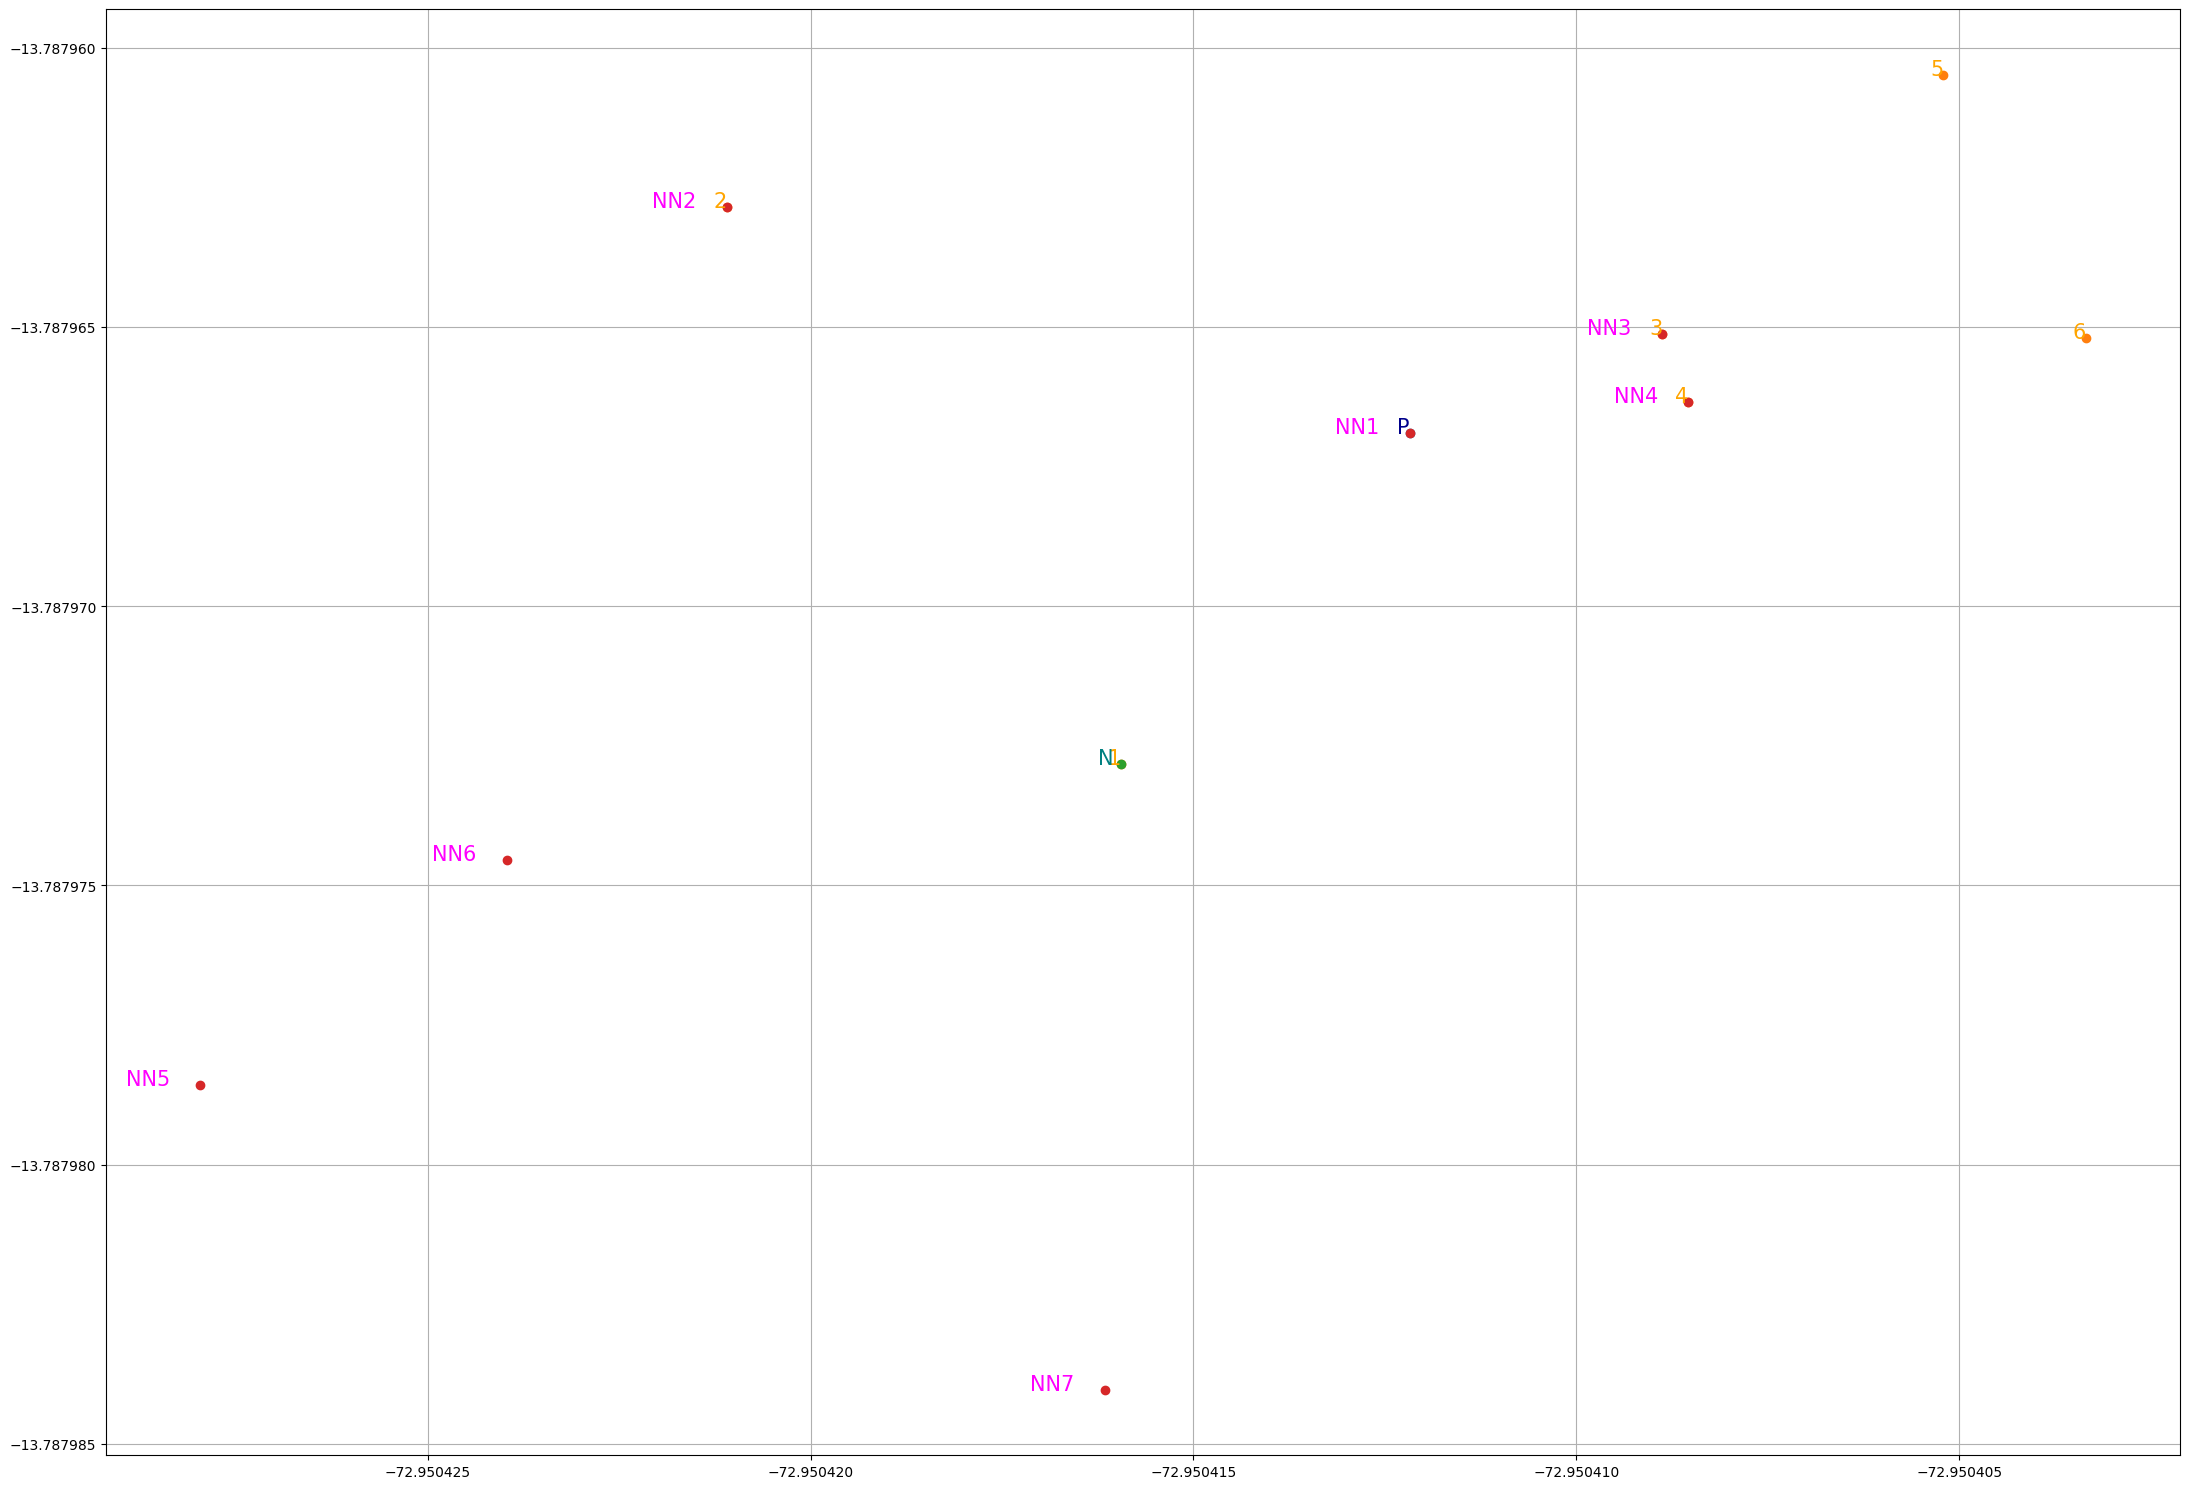

In [6]:
import matplotlib.pyplot as plt

points_neighbords = [[-13.787972834900415, -72.95041594796696], [-13.78796284393943, -72.95042109626344], [-13.787965130887258, -72.9504088790114], [-13.787966337393788, -72.9504085358206], [-13.787960483740502, -72.9504052058341], [-13.787965203959878, -72.95040334693887]]


colores = [
    "darkblue", "orange", "teal", "magenta", "gold", 
    "indigo", "lime", "turquoise", "orchid", "coral", 
    "crimson", "cyan", "darkgreen", "deeppink", "lavender", 
    "navy", "olive", "peru", "plum", "salmon", 
    "sienna", "silver", "slateblue", "springgreen", "steelblue", 
    "tan", "thistle", "tomato", "violet", "wheat", 
    "aquamarine", "azure", "beige", "bisque", "blueviolet", 
    "brown", "chartreuse", "chocolate", "cornflowerblue", "darkcyan", 
    "darkgoldenrod", "darkkhaki", "darkmagenta", "darkorange", "darkorchid", 
    "darksalmon", "darkseagreen", "darkslateblue", "darkturquoise", "firebrick",
    "forestgreen", "gainsboro", "ghostwhite", "greenyellow", "honeydew", 
    "hotpink", "ivory", "khaki", "lavenderblush", "lawngreen", 
    "lemonchiffon", "lightblue", "lightcoral", "lightcyan", "lightgoldenrodyellow", 
    "lightgreen", "lightgrey", "lightpink", "lightsalmon", "lightseagreen", 
    "lightskyblue", "lightslategray", "lightsteelblue", "lightyellow", "limegreen", 
    "linen", "mediumaquamarine", "mediumblue", "mediumorchid", "mediumpurple", 
    "mediumseagreen", "mediumslateblue", "mediumspringgreen", "mediumturquoise", "mediumvioletred", 
    "midnightblue", "mintcream", "mistyrose", "moccasin", "navajowhite", 
    "oldlace", "olivedrab", "orangered", "palegoldenrod", "palegreen", 
    "paleturquoise", "palevioletred", "papayawhip", "peachpuff", "powderblue"
]

point = [-13.787966897188113, -72.95041217231403]
point_neighbord = [-13.787972834900415, -72.95041594796696]

points_neighbords_neighbord = [[-13.787966897188113, -72.95041217231403], [-13.78796284393943, -72.95042109626344], [-13.787965130887258, -72.9504088790114], [-13.787966337393788, -72.9504085358206], [-13.78797857963158, -72.95042796878762], [-13.787974538098219, -72.95042396718758], [-13.787984029495078, -72.9504161528893]]

fig = plt.figure(figsize=(22, 15))

plt.scatter(point[1] , point[0])
plt.text(point[1], point[0], str('P'), fontsize = 15, ha = "right", color = colores[0])

latitudes, longitudes = zip(*points_neighbords[:])
plt.scatter(longitudes , latitudes)
for j, (x, y) in enumerate(zip(longitudes, latitudes)):
    plt.text(x, y, str(j + 1), fontsize = 15, ha = "right", color = colores[1])

plt.ticklabel_format(useOffset=False, style='plain', axis='both')

plt.scatter(point_neighbord[1] , point_neighbord[0])
plt.text(point_neighbord[1] - 0.0000001, point_neighbord[0], str('N'), fontsize = 15, ha = "right", color = colores[2])

latitudes, longitudes = zip(*points_neighbords_neighbord[:])
plt.scatter(longitudes , latitudes)
for j, (x, y) in enumerate(zip(longitudes, latitudes)):
    plt.text(x - 0.0000004 , y, 'NN' + str(j + 1), fontsize = 15, ha = "right", color = colores[3])

plt.ticklabel_format(useOffset=False, style='plain', axis='both')


plt.grid(True)
# Mostrar la figura completa
plt.tight_layout()
plt.show()

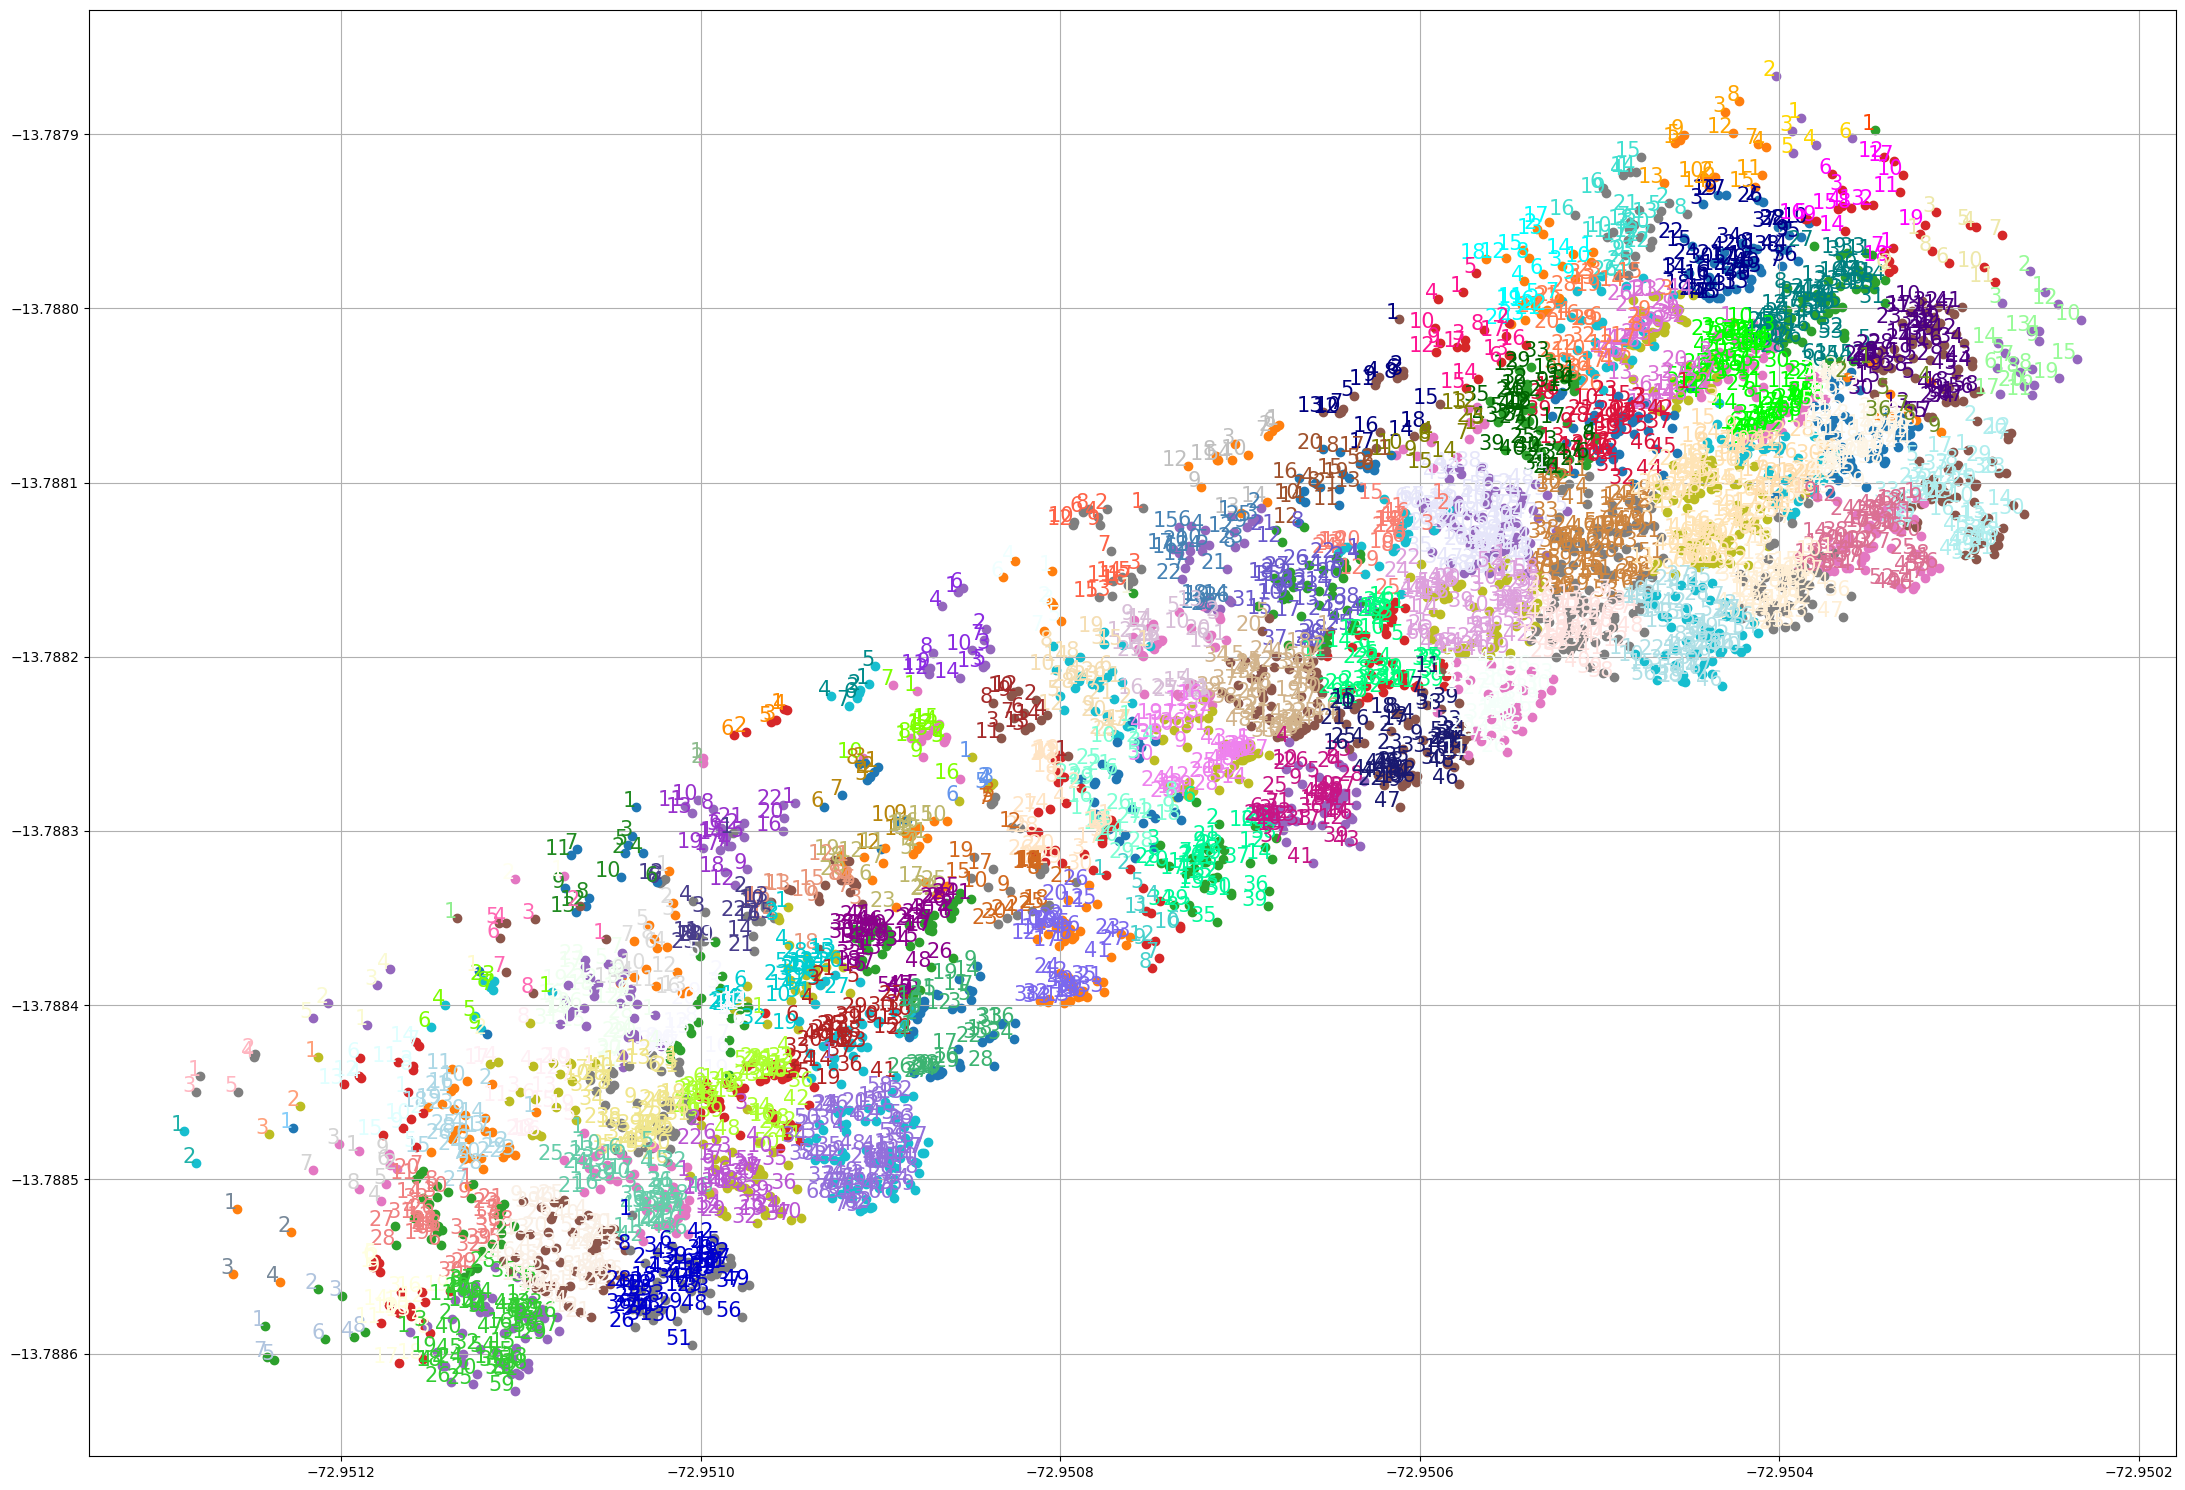

In [7]:
colores = [
    "darkblue", "orange", "teal", "magenta", "gold", 
    "indigo", "lime", "turquoise", "orchid", "coral", 
    "crimson", "cyan", "darkgreen", "deeppink", "lavender", 
    "navy", "olive", "peru", "plum", "salmon", 
    "sienna", "silver", "slateblue", "springgreen", "steelblue", 
    "tan", "thistle", "tomato", "violet", "wheat", 
    "aquamarine", "azure", "beige", "bisque", "blueviolet", 
    "brown", "chartreuse", "chocolate", "cornflowerblue", "darkcyan", 
    "darkgoldenrod", "darkkhaki", "darkmagenta", "darkorange", "darkorchid", 
    "darksalmon", "darkseagreen", "darkslateblue", "darkturquoise", "firebrick",
    "forestgreen", "gainsboro", "ghostwhite", "greenyellow", "honeydew", 
    "hotpink", "ivory", "khaki", "lavenderblush", "lawngreen", 
    "lemonchiffon", "lightblue", "lightcoral", "lightcyan", "lightgoldenrodyellow", 
    "lightgreen", "lightgrey", "lightpink", "lightsalmon", "lightseagreen", 
    "lightskyblue", "lightslategray", "lightsteelblue", "lightyellow", "limegreen", 
    "linen", "mediumaquamarine", "mediumblue", "mediumorchid", "mediumpurple", 
    "mediumseagreen", "mediumslateblue", "mediumspringgreen", "mediumturquoise", "mediumvioletred", 
    "midnightblue", "mintcream", "mistyrose", "moccasin", "navajowhite", 
    "oldlace", "olivedrab", "orangered", "palegoldenrod", "palegreen", 
    "paleturquoise", "palevioletred", "papayawhip", "peachpuff", "powderblue"
]


fig = plt.figure(figsize=(22, 15))

for i in range(100):
    latitudes, longitudes = zip(*groups[i])
    plt.scatter(longitudes , latitudes)
    for j, (x, y) in enumerate(zip(longitudes, latitudes)):
        plt.text(x, y, str(j + 1), fontsize = 15, ha = "right", color = colores[i])

    plt.ticklabel_format(useOffset=False, style='plain', axis='both')


plt.grid(True)
# Mostrar la figura completa
plt.tight_layout()
plt.show()

In [8]:
import json

def select_point_by_distance_center(group_idx, centers, img_center_ref):
    if len(group_idx) == 1:
        return group_idx[0]
    
    distances = [euclidean_distance(cent, img_center_ref) for cent in centers]

    idx = np.argmin(distances)
    return group_idx[idx]

def save_img(image, path_save):
    img = Image.fromarray(image)
    img.save(path_save)

def save_json(data, path_save):
    with open(path_save, "w", encoding="utf-8") as json_file:
        json.dump(data, json_file, indent=4, ensure_ascii=False)

centers_trees = [cent for centers_trees_img in centers_ref_images for cent in centers_trees_img]
img_center = image_width // 2, image_heigth // 2


filtered_trees_idx = [select_point_by_distance_center(group_idx, 
                                                      [centers_trees[idx] for idx in group_idx], 
                                                      img_center) 
                        for group_idx in groups_idx]


filtered_coordinates = [coordinates[idx] for idx in filtered_trees_idx]
names = [f"T{i+1}" for i in range(len(filtered_trees_idx))]

print(f"{len(filtered_trees_idx)} arboles encontrados")

375 arboles encontrados


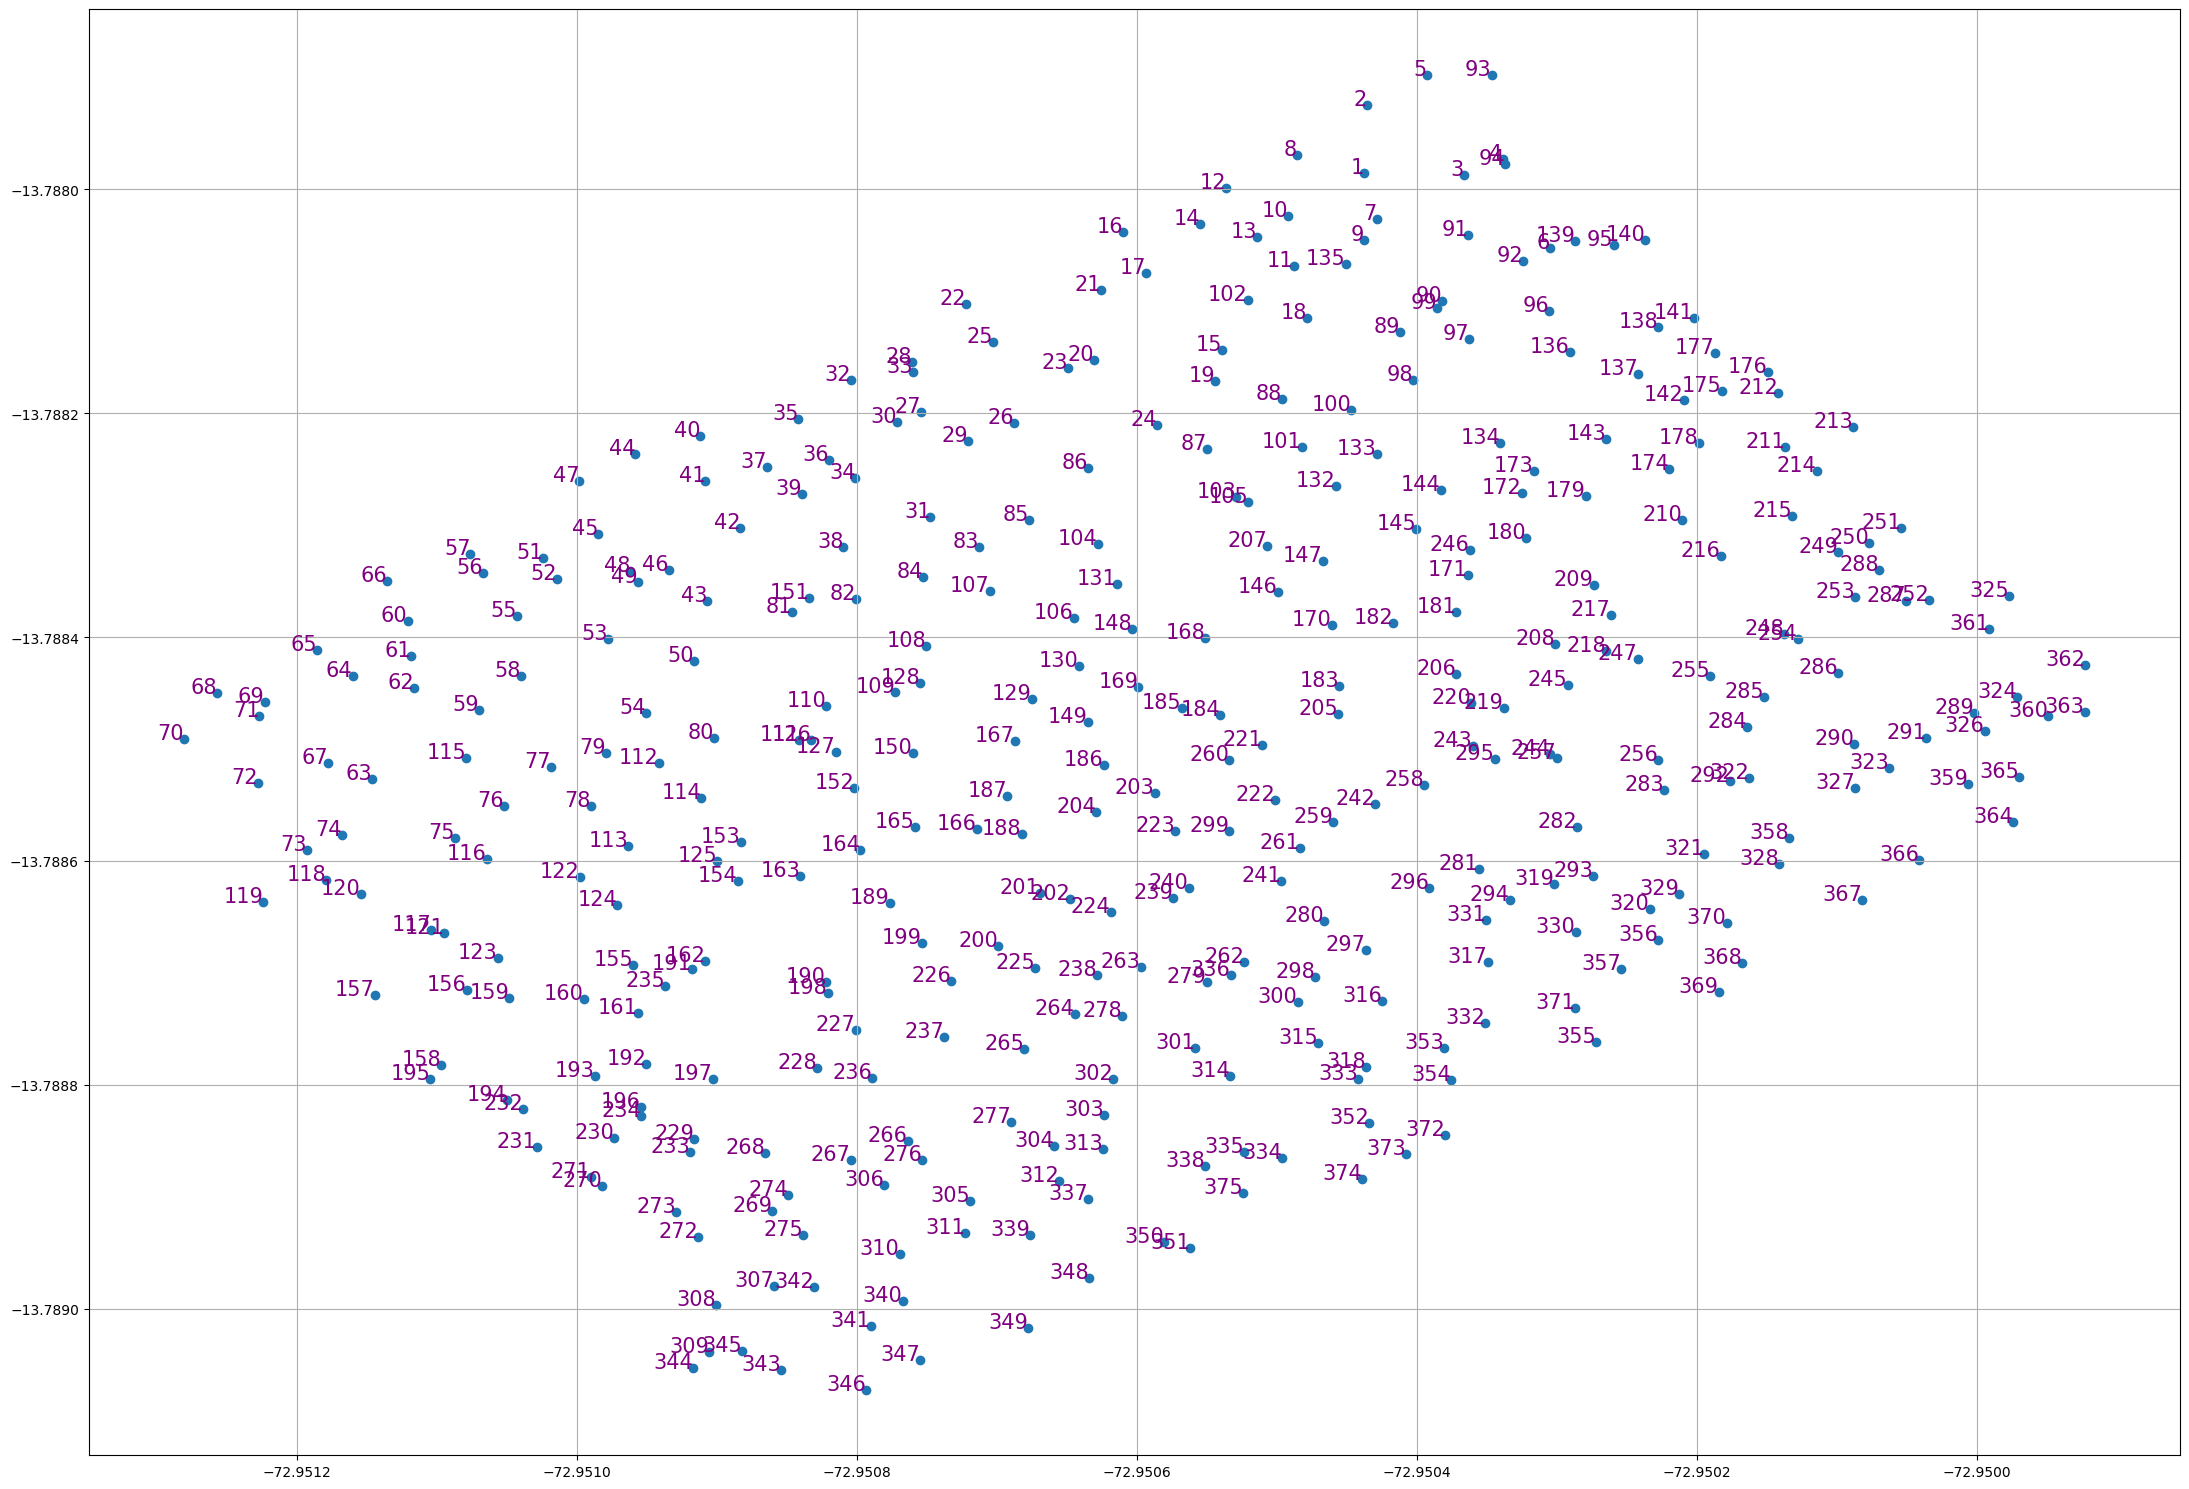

In [315]:
fig = plt.figure(figsize=(22, 15))


latitudes, longitudes = zip(*filtered_coordinates[0:])
plt.scatter(longitudes , latitudes)
for i, (x, y) in enumerate(zip(longitudes, latitudes)):
    plt.text(x, y, str(i + 1), fontsize = 15, ha = "right", color = "purple")
plt.ticklabel_format(useOffset=False, style='plain', axis='both')


plt.grid(True)
# Mostrar la figura completa
plt.tight_layout()
plt.show()

In [9]:
import pyproj

# Datos UTM
easting = 721512.20  # Coordenada Este (Easting)
northing = 8474688.38  # Coordenada Norte (Northing)
zone_number = 18
hemisphere = 'south'  # Hemisferio sur

# Configuración del sistema de referencia UTM (Zona 18S) y WGS84 (geográfico)
utm_proj = pyproj.Proj(proj='utm', zone=zone_number, south=True, datum='WGS84')
wgs84_proj = pyproj.Proj(proj='latlong', datum='WGS84')

# Conversión de UTM a Latitud y Longitud
longitude, latitude = pyproj.transform(utm_proj, wgs84_proj, easting, northing)
latitude, longitude

C:\Users\antho\AppData\Local\Temp\ipykernel_2800\2861488528.py:14: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  longitude, latitude = pyproj.transform(utm_proj, wgs84_proj, easting, northing)


(-13.788786113210529, -72.95103365527245)

In [10]:
execeso_coords = [
    [-72.95112602834315, -13.788658738446593],  # Punto 1 (lon, lat)
    [-72.95087630412239, -13.789016691043022],  # Punto 2
    [-72.9505961677411, -13.788854401238005],  # Punto 4
    [-72.9508616817858, -13.788498930176383],  # Punto 3
    [-72.95112602834315, -13.788658738446593],  # Punto 4
]

control_coords = [
    [-72.9508616817858, -13.788498930176383],  # Punto 1 (lon, lat)
    [-72.95060124778658, -13.788367620806463],  # Punto 2
    [-72.95041537927345, -13.788761530161311],  # Punto 3
    [-72.9505961677411, -13.788854401238005],  # Punto 4
    [-72.9508616817858, -13.788498930176383],  # Punto 4
]

deficiencia_coords = [
    [-72.95060124778658, -13.788367620806463],  # Punto 1 (lon, lat)
    [-72.95042004234736, -13.788756960169628],  # Punto 2
    [-72.9501746824794, -13.788604177601943],  # Punto 3
    [-72.95037064098769, -13.788261953797358],
    [-72.95060124778658, -13.788367620806463]  # Punto 4
    #[],  # Punto 4

]

nitrogen_coords = [
    [-72.95091124103082, -13.788933570781541],
    [-72.9502027757155,  -13.788542418072122],
    [-72.95017141020345,  -13.788608307335005],
    [-72.95087630412239, -13.789016691043022],
    [-72.95091124103082, -13.788933570781541],
]


fosforo_coords = [
    [-72.95097928824111, -13.788870698221828],
    [-72.9502464868807,  -13.788471028795405],
    [-72.9502027757155,  -13.788542418072122],
    [-72.95091124103082, -13.788933570781541],
    [-72.95097928824111, -13.788870698221828]
]

potasio_coords = [
    [-72.95103365527245, -13.788786113210529],
    [-72.95097928824111, -13.788870698221828],  # Punto 2
    [-72.95020774191423, -13.78846836806144],  # Punto 3
    [-72.95024507873612, -13.78841263135663],  # Punto 4
    [-72.95095575587074, -13.78876600457266],  # Punto 4
]

In [11]:
from shapely.geometry import Point, Polygon
import pandas as pd

#execeso_coords = [
#    [-72.95106691588181, -13.78862151465264],  # Punto 1 (lon, lat)
#    [-72.95078355149198, -13.78896960404037],  # Punto 2
#    [-72.95058977239535, -13.78884503212221],  # Punto 3
#    [-72.95084878777465, -13.78850485979336],  # Punto 4
#    [-72.95106691588181, -13.78862151465264],  # Punto 4
#]

#control_coords = [
#    [-72.95058857268376, -13.78884566094881],  # Punto 1 (lon, lat)
#    [-72.95038102508796, -13.78871635088031],  # Punto 2
#    [-72.95057833604888, -13.78837171191893],  # Punto 3
#    [-72.95084479714127, -13.78850459660267],  # Punto 4
#    [-72.95058857268376, -13.78884566094881],  # Punto 4
#]

#deficiencia_coords = [
#    [-72.95037759625318, -13.78872124454571],  # Punto 1 (lon, lat)
#    [-72.95013587285041, -13.78857441271449],  # Punto 2
#    [-72.95033752901116, -13.78826125370682],  # Punto 3
#    [-72.95057127894071, -13.78837041139576],  # Punto 4
#    [-72.95037759625318, -13.78872124454571],  # Punto 4
#]

agua50_coords = [
    [-72.95113916637912, -13.78851700375371], 
    [-72.95108810503011, -13.78858677984862], 
    [-72.95036010768648, -13.78823076443791], 
    [-72.95041016941488, -13.78816356142161], 
    [-72.95113916637912, -13.78851700375371]   
]

agua75_coords = [
    [-72.95118430882835, -13.78844248960293], 
    [-72.95114761039147, -13.78851625026622], 
    [-72.95042117186838, -13.7881548004523], 
    [-72.95045031945472, -13.78809277665114], 
    [-72.95118430882835, -13.78844248960293]   
]

agua100_coords = [
    [-72.95120760556891, -13.78836513503285], 
    [-72.9511870293633, -13.7884458405465], 
    [-72.95045748494876, -13.78809389807375], 
    [-72.95049527987159, -13.78802914350277], 
    [-72.95120760556891, -13.78836513503285]   
]

def filter_trees_in_areas(coordinates, trees_idx, areas_coords):
    poligonos = [ Polygon(area_coords) for area_coords in  areas_coords]
    filtered = [[punto, idx] for punto, idx in zip(coordinates, trees_idx) 
                                        if any([poligono.contains(Point([punto[1], punto[0]])) for poligono in poligonos])]
    filtered_points, filtered_trees_idx = zip(*filtered) if filtered else [[], []] 
    return filtered_points, filtered_trees_idx

areas_coords = [
    execeso_coords, 
    control_coords, 
    deficiencia_coords, 
    #agua50_coords, 
    #agua75_coords, 
    #agua100_coords
    ]

filtered_coordinates, filtered_trees_idx = filter_trees_in_areas(filtered_coordinates, filtered_trees_idx, areas_coords)
    
names = [f"T{i+1}" for i in range(len(filtered_trees_idx))]

print(f"{len(filtered_trees_idx)} arboles encontrados")

142 arboles encontrados


In [14]:
import plotly.express as px
import plotly.graph_objects as go

mapbox_token = "pk.eyJ1IjoiYW50aG9ueW1nMSIsImEiOiJjbTNuajBzamwxZXMxMmtweDV3anZkcHRxIn0.1ZlgQwJcn4msckpzTNSSJg"
latitudes, longitudes = zip(*filtered_coordinates[:])

fig = px.scatter_mapbox(
    lat=latitudes,  # Latitud de ejemplo (San Francisco)
    lon=longitudes,  # Longitud de ejemplo (San Francisco)
    zoom=18,  # Nivel de zoom
    height=800,  # Altura del gráfico
    hover_name=names
)

# Configurar el mapa con el estilo satelital
fig.update_layout(
    mapbox_style="satellite",  # Estilo de mapa satelital
    mapbox_accesstoken=mapbox_token  # Tu token de acceso Mapbox
)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

mapbox_token = "pk.eyJ1IjoiYW50aG9ueW1nMSIsImEiOiJjbTNuajBzamwxZXMxMmtweDV3anZkcHRxIn0.1ZlgQwJcn4msckpzTNSSJg"
latitudes, longitudes = zip(*filtered_coordinates[:])

fig = px.scatter_mapbox(
    lat=latitudes,  # Latitud de ejemplo (San Francisco)
    lon=longitudes,  # Longitud de ejemplo (San Francisco)
    zoom=18,  # Nivel de zoom
    height=800,  # Altura del gráfico
    hover_name=names
)

# Configurar el mapa con el estilo satelital
fig.update_layout(
    mapbox_style="satellite",  # Estilo de mapa satelital
    mapbox_accesstoken=mapbox_token  # Tu token de acceso Mapbox
)

# Agregar el polígono al mapa
fig.add_trace(
    go.Scattermapbox(
        mode="lines",  # Polígono dibujado con líneas
        lon=[point[0] for point in execeso_coords],  # Longitudes del polígono
        lat=[point[1] for point in execeso_coords],  # Latitudes del polígono
        fill="toself",  # Rellenar el interior del polígono
        fillcolor="rgba(255, 150, 0, 0.3)",  # Color con transparencia
        line=dict(color="orange", width=2),  # Configuración del borde
        name="Exceso"  # Etiqueta opcional
    )
)


# Agregar el polígono al mapa
fig.add_trace(
    go.Scattermapbox(
        mode="lines",  # Polígono dibujado con líneas
        lon=[point[0] for point in control_coords],  # Longitudes del polígono
        lat=[point[1] for point in control_coords],  # Latitudes del polígono
        fill="toself",  # Rellenar el interior del polígono
        fillcolor="rgba(0, 150, 255, 0.3)",  # Color con transparencia
        line=dict(color="blue", width=2),  # Configuración del borde
        name="Control"  # Etiqueta opcional
    )
)

# Agregar el polígono al mapa
fig.add_trace(
    go.Scattermapbox(
        mode="lines",  # Polígono dibujado con líneas
        lon=[point[0] for point in deficiencia_coords],  # Longitudes del polígono
        lat=[point[1] for point in deficiencia_coords],  # Latitudes del polígono
        fill="toself",  # Rellenar el interior del polígono
        fillcolor="rgba(255, 255, 0, 0.3)",  # Color con transparencia
        line=dict(color="yellow", width=2),  # Configuración del borde
        name="Deficiencias"  # Etiqueta opcional
    )
)

colores_transparentes = [
    "rgba(255, 0, 0, 0.3)",    # Rojo translúcido
    "rgba(0, 255, 0, 0.3)",    # Verde translúcido
    "rgba(0, 0, 255, 0.3)",    # Azul translúcido
    "rgba(255, 255, 0, 0.3)",  # Amarillo translúcido
    "rgba(255, 165, 0, 0.3)",  # Naranja translúcido
    "rgba(128, 0, 128, 0.3)",  # Morado translúcido
    "rgba(0, 255, 255, 0.3)",  # Cian translúcido
    "rgba(255, 0, 255, 0.3)",  # Magenta translúcido
    "rgba(0, 128, 0, 0.3)",    # Verde oscuro translúcido
    "rgba(128, 128, 128, 0.3)",# Gris translúcido
    "rgba(255, 182, 193, 0.3)",# Rosa translúcido
    "rgba(139, 69, 19, 0.3)",  # Marrón translúcido
    "rgba(255, 140, 0, 0.3)",  # Naranja oscuro translúcido
    "rgba(173, 216, 230, 0.3)",# Azul claro translúcido
    "rgba(75, 0, 130, 0.3)",   # Índigo translúcido
    "rgba(240, 128, 128, 0.3)",# Salmón translúcido
    "rgba(60, 179, 113, 0.3)", # Verde medio translúcido
    "rgba(221, 160, 221, 0.3)",# Orquídea translúcida
    "rgba(0, 191, 255, 0.3)",  # Azul cielo profundo translúcido
    "rgba(255, 20, 147, 0.3)"  # Rosa profundo translúcido
]

# Colores opacos para los bordes
colores_bordes = [
    "rgb(255, 0, 0)", "rgb(0, 255, 0)", "rgb(0, 0, 255)", "rgb(255, 255, 0)", "rgb(255, 165, 0)",
    "rgb(128, 0, 128)", "rgb(0, 255, 255)", "rgb(255, 0, 255)", "rgb(0, 128, 0)", "rgb(128, 128, 128)",
    "rgb(255, 182, 193)", "rgb(139, 69, 19)", "rgb(255, 140, 0)", "rgb(173, 216, 230)",
    "rgb(75, 0, 130)", "rgb(240, 128, 128)", "rgb(60, 179, 113)", "rgb(221, 160, 221)",
    "rgb(0, 191, 255)", "rgb(255, 20, 147)"
]



# Coordenadas del polígono (pueden ser dinámicas)
#nitrogen_coords = [
#    [-72.95013568946361, -13.78857620412611],  # Punto 1 (lon, lat)
#    [-72.95016605894592, -13.78852532251371],  # Punto 2
#    [-72.95084104920073, -13.78889615030833],  # Punto 3
#    [-72.95078179856594, -13.78896508200927],  # Punto 4
#    [-72.95013568946361, -13.78857620412611],  # Punto 4
#]

# Agregar el polígono al mapa
fig.add_trace(
    go.Scattermapbox(
        mode="lines",  # Polígono dibujado con líneas
        lon=[point[0] for point in nitrogen_coords],  # Longitudes del polígono
        lat=[point[1] for point in nitrogen_coords],  # Latitudes del polígono
        fill="toself",  # Rellenar el interior del polígono
        fillcolor=colores_transparentes[5],  # Color con transparencia
        line=dict(color=colores_bordes[5], width=2),  # Configuración del borde
        name="Nitrogeno"  # Etiqueta opcional
    )
)

# Coordenadas del polígono (pueden ser dinámicas)
#fosforo_coords = [
#    [-72.95089909013008, -13.78882838422602],  # Punto 1 (lon, lat)
#    [-72.95086597977421, -13.7888729217457],  # Punto 2
#    [-72.95084113638691, -13.78890003927562],  # Punto 3
#    [-72.95016959056757, -13.78852551042641],  # Punto 4
#    [-72.95020649469058, -13.78846839367988],  # Punto 4
#    [-72.95089909013008, -13.78882838422602],  # Punto 4
#]

# Agregar el polígono al mapa
fig.add_trace(
    go.Scattermapbox(
        mode="lines",  # Polígono dibujado con líneas
        lon=[point[0] for point in fosforo_coords],  # Longitudes del polígono
        lat=[point[1] for point in fosforo_coords],  # Latitudes del polígono
        fill="toself",  # Rellenar el interior del polígono
        fillcolor=colores_transparentes[6],  # Color con transparencia
        line=dict(color=colores_bordes[6], width=2),  # Configuración del borde
        name="Fosforo"  # Etiqueta opcional
    )
)

# Coordenadas del polígono (pueden ser dinámicas)
#potasio_coords = [
#    [-72.95095575587074, -13.78876600457266],  # Punto 1 (lon, lat)
#    [-72.95090142130681, -13.78882857576273],  # Punto 2
#    [-72.95020774191423, -13.78846836806144],  # Punto 3
#    [-72.95024507873612, -13.78841263135663],  # Punto 4
#    [-72.95095575587074, -13.78876600457266],  # Punto 4
#]

# Agregar el polígono al mapa
fig.add_trace(
    go.Scattermapbox(
        mode="lines",  # Polígono dibujado con líneas
        lon=[point[0] for point in potasio_coords],  # Longitudes del polígono
        lat=[point[1] for point in potasio_coords],  # Latitudes del polígono
        fill="toself",  # Rellenar el interior del polígono
        fillcolor=colores_transparentes[7],  # Color con transparencia
        line=dict(color=colores_bordes[7], width=2),  # Configuración del borde
        name="Potasio"  # Etiqueta opcional
    )
)

#magenesio_coords = [ 
#    [-72.95100412265217, -13.7886892277678], 
#    [-72.95095171958101, -13.78875947591848], 
#    [-72.95024497090068, -13.78840815570143], 
#    [-72.95028418467145, -13.78834329209831], 
#    [-72.95100412265217, -13.7886892277678]
#]

# Agregar el polígono al mapa
#fig.add_trace(
#    go.Scattermapbox(
#        mode="lines",  # Polígono dibujado con líneas
#        lon=[point[0] for point in magenesio_coords],  # Longitudes del polígono
#        lat=[point[1] for point in magenesio_coords],  # Latitudes del polígono
#        fill="toself",  # Rellenar el interior del polígono
#        fillcolor=colores_transparentes[8],  # Color con transparencia
#        line=dict(color=colores_bordes[8], width=2),  # Configuración del borde
#        name="Magnesio"  # Etiqueta opcional
#    )
#)


#zinc_coords = [ 
#    [-72.95107522928183,-13.78862183157668], 
#    [-72.95101845443234, -13.78869051236703], 
#    [-72.95029053901351, -13.78834122292662], 
#    [-72.95033438779834, -13.78825878092399], 
#    [-72.95107522928183, -13.78862183157668]
#]

# Agregar el polígono al mapa
#fig.add_trace(
#    go.Scattermapbox(
#        mode="lines",  # Polígono dibujado con líneas
#        lon=[point[0] for point in zinc_coords],  # Longitudes del polígono
#        lat=[point[1] for point in zinc_coords],  # Latitudes del polígono
#        fill="toself",  # Rellenar el interior del polígono
#        fillcolor=colores_transparentes[9],  # Color con transparencia
#        line=dict(color=colores_bordes[9], width=2),  # Configuración del borde
#        name="Zinc"  # Etiqueta opcional
#    )
#)

# Agregar el polígono al mapa
#fig.add_trace(
#    go.Scattermapbox(
#        mode="lines",  # Polígono dibujado con líneas
#        lon=[point[0] for point in agua50_coords],  # Longitudes del polígono
#        lat=[point[1] for point in agua50_coords],  # Latitudes del polígono

#        fill="toself",  # Rellenar el interior del polígono
#        fillcolor=colores_transparentes[10],  # Color con transparencia
#        line=dict(color=colores_bordes[10], width=2),  # Configuración del borde
#        name="Agua-50%"  # Etiqueta opcional
#    )
#)



# Agregar el polígono al mapa
#fig.add_trace(
#    go.Scattermapbox(
#        mode="lines",  # Polígono dibujado con líneas
#        lon=[point[0] for point in agua75_coords],  # Longitudes del polígono
#        lat=[point[1] for point in agua75_coords],  # Latitudes del polígono
#        fill="toself",  # Rellenar el interior del polígono
#        fillcolor=colores_transparentes[11],  # Color con transparencia
#        line=dict(color=colores_bordes[11], width=2),  # Configuración del borde
#        name="Agua-75%"  # Etiqueta opcional
#    )
#)

# Agregar el polígono al mapa
#fig.add_trace(
#    go.Scattermapbox(
#        mode="lines",  # Polígono dibujado con líneas
#        lon=[point[0] for point in agua100_coords],  # Longitudes del polígono
#        lat=[point[1] for point in agua100_coords],  # Latitudes del polígono
#        fill="toself",  # Rellenar el interior del polígono
#        fillcolor=colores_transparentes[12],  # Color con transparencia
#        line=dict(color=colores_bordes[12], width=2),  # Configuración del borde
#        name="Agua-100%"  # Etiqueta opcional
#    )
#)
# Mostrar el mapa
fig.show()

In [320]:
from shapely.geometry import Point, Polygon
import pandas as pd
# Función para filtrar puntos
def filtrar_puntos_dentro_poligono(puntos, poligono):
    puntos_dentro = [punto for punto in puntos if poligono.contains(Point(punto))]
    return puntos_dentro

def get_names_trees_in_area(area_coords, points, names):
    poligono = Polygon(area_coords)
    filtered_points = [[name, punto] for punto, name in zip(points, names) if poligono.contains(Point(punto))]
    filtered_names, filtered_points = zip(*filtered_points)
    return filtered_names, filtered_points

# Filter puntos exceso
puntos_invertidos = [(lon, lat) for lat, lon in filtered_coordinates]

execeso_names_trees, execeso_coord_trees = get_names_trees_in_area(execeso_coords, puntos_invertidos, names)

control_names_trees, control_coord_trees = get_names_trees_in_area(control_coords, puntos_invertidos, names)

deficiencia_names_trees, deficiencia_coord_trees = get_names_trees_in_area(deficiencia_coords, puntos_invertidos, names)

nitrogen_names_trees, nitrogen_coord_trees = get_names_trees_in_area(nitrogen_coords, puntos_invertidos, names)

fosforo_names_trees, fosforo_coord_trees = get_names_trees_in_area(fosforo_coords, puntos_invertidos, names)

potasio_names_trees, potasio_coord_trees = get_names_trees_in_area(potasio_coords, puntos_invertidos, names)

#magenesio_names_trees, magenesio_coord_trees = get_names_trees_in_area(magenesio_coords, puntos_invertidos, names)

#zinc_names_trees, zinc_coord_trees = get_names_trees_in_area(zinc_coords, puntos_invertidos, names)

#agua50_names_trees, agua50_coord_trees = get_names_trees_in_area(agua50_coords, puntos_invertidos, names)

#agua75_names_trees, agua75_coord_trees = get_names_trees_in_area(agua75_coords, puntos_invertidos, names)

#agua100_names_trees, agua100_coord_trees = get_names_trees_in_area(agua100_coords, puntos_invertidos, names)

names_final = execeso_names_trees + control_names_trees + deficiencia_names_trees #+ agua50_names_trees + agua75_names_trees + agua100_names_trees
coords_finals = execeso_coord_trees + control_coord_trees + deficiencia_coord_trees
long_final, lat_final = zip(*coords_finals)

tratamiento = ["exceso"] * len(execeso_names_trees) + \
              ["control"] * len(control_names_trees) + \
              ["deficiencia"] * len(deficiencia_names_trees) #+ \
              #["agua-50%"] * len(agua50_names_trees) + \
              #["agua-75%"] * len(agua75_names_trees) + \
              #["agua-100%"] * len(agua100_names_trees)

df_data = pd.DataFrame({"nombre": names_final, "tratamiento": tratamiento, "longitude": long_final, "latitude": lat_final})

# Crear la columna 'nutriente' con valores iniciales, por ejemplo, vacío
df_data['nutriente'] = ""

# Asignar valores a la columna 'nutriente' basados en las condiciones
df_data.loc[df_data["nombre"].isin(nitrogen_names_trees), "nutriente"] = "N"
df_data.loc[df_data["nombre"].isin(fosforo_names_trees), "nutriente"] = "P"
df_data.loc[df_data["nombre"].isin(potasio_names_trees), "nutriente"] = "K"

#df_data[df_data["nombre"] == pd.Series(nitrogen_names_trees)] = ['N']
#df_data[df_data["nombre"] == pd.Series(fosforo_names_trees)] = ['P']
#df_data[df_data["nombre"] == pd.Series(potasio_names_trees)] = ['K']
#df_data[df_data["nombre"] == pd.Series(magenesio_names_trees)] = ['Mg']
#df_data[df_data["nombre"] == pd.Series(zinc_names_trees)] = ['Zinc']
#df_data[df_data["nombre"] == pd.Series(agua50_names_trees)] = ['H2O']
#df_data[df_data["nombre"] == pd.Series(agua75_names_trees)] = ['H2O']
#df_data[df_data["nombre"] == pd.Series(agua100_names_trees)] = ['H2O']

df_data.to_csv("data.csv")
df_data

nombre  tratamiento  longitude   latitude nutriente
0       T2       exceso -72.950963 -13.788587          
1       T3       exceso -72.950911 -13.788544          
2       T4       exceso -72.951104 -13.788662          
3       T5       exceso -72.951095 -13.788664          
4       T6       exceso -72.950998 -13.788614          
..     ...          ...        ...        ...       ...
139   T136  deficiencia -72.950350 -13.788691         N
140   T137  deficiencia -72.950302 -13.788621         N
141   T138  deficiencia -72.950195 -13.788594         N
142   T139  deficiencia -72.950287 -13.788663         N
143   T140  deficiencia -72.950351 -13.788653         N

[144 rows x 5 columns]

In [322]:
import shutil
def save_trees(output_dir, temp_dir, filtered_trees_idx, filtered_coordinates, names):
    for i in tqdm(range(len(filtered_trees_idx)), desc="Trees"):
        idx = filtered_trees_idx[i]
        coordinate = filtered_coordinates[i]
        save_dir = f"{output_dir}/{names[i]}"
        
        os.makedirs(save_dir, exist_ok=True)
        
        temp_file_tree = f"{temp_dir}/Tree-D{idx}.png"
        temp_file_seg = f"{temp_dir}/Seg-D{idx}.png"
        temp_file_mask = f"{temp_dir}/Mask-D{idx}.png"
        
        shutil.copy(temp_file_tree, f"{save_dir}/original.png")
        shutil.copy(temp_file_seg, f"{save_dir}/segmentado.png")
        shutil.copy(temp_file_mask, f"{save_dir}/mascara.png")

        metadata = {"latitude": coordinate[0], 
                    "longitude": coordinate[1]}
        
        save_json(metadata, f"{save_dir}/metadata.json")

output_dir = "./output/trees"
save_trees(output_dir, temp_dir, filtered_trees_idx , filtered_coordinates, names)

Trees: 100%|██████████| 142/142 [00:01<00:00, 89.00it/s] 


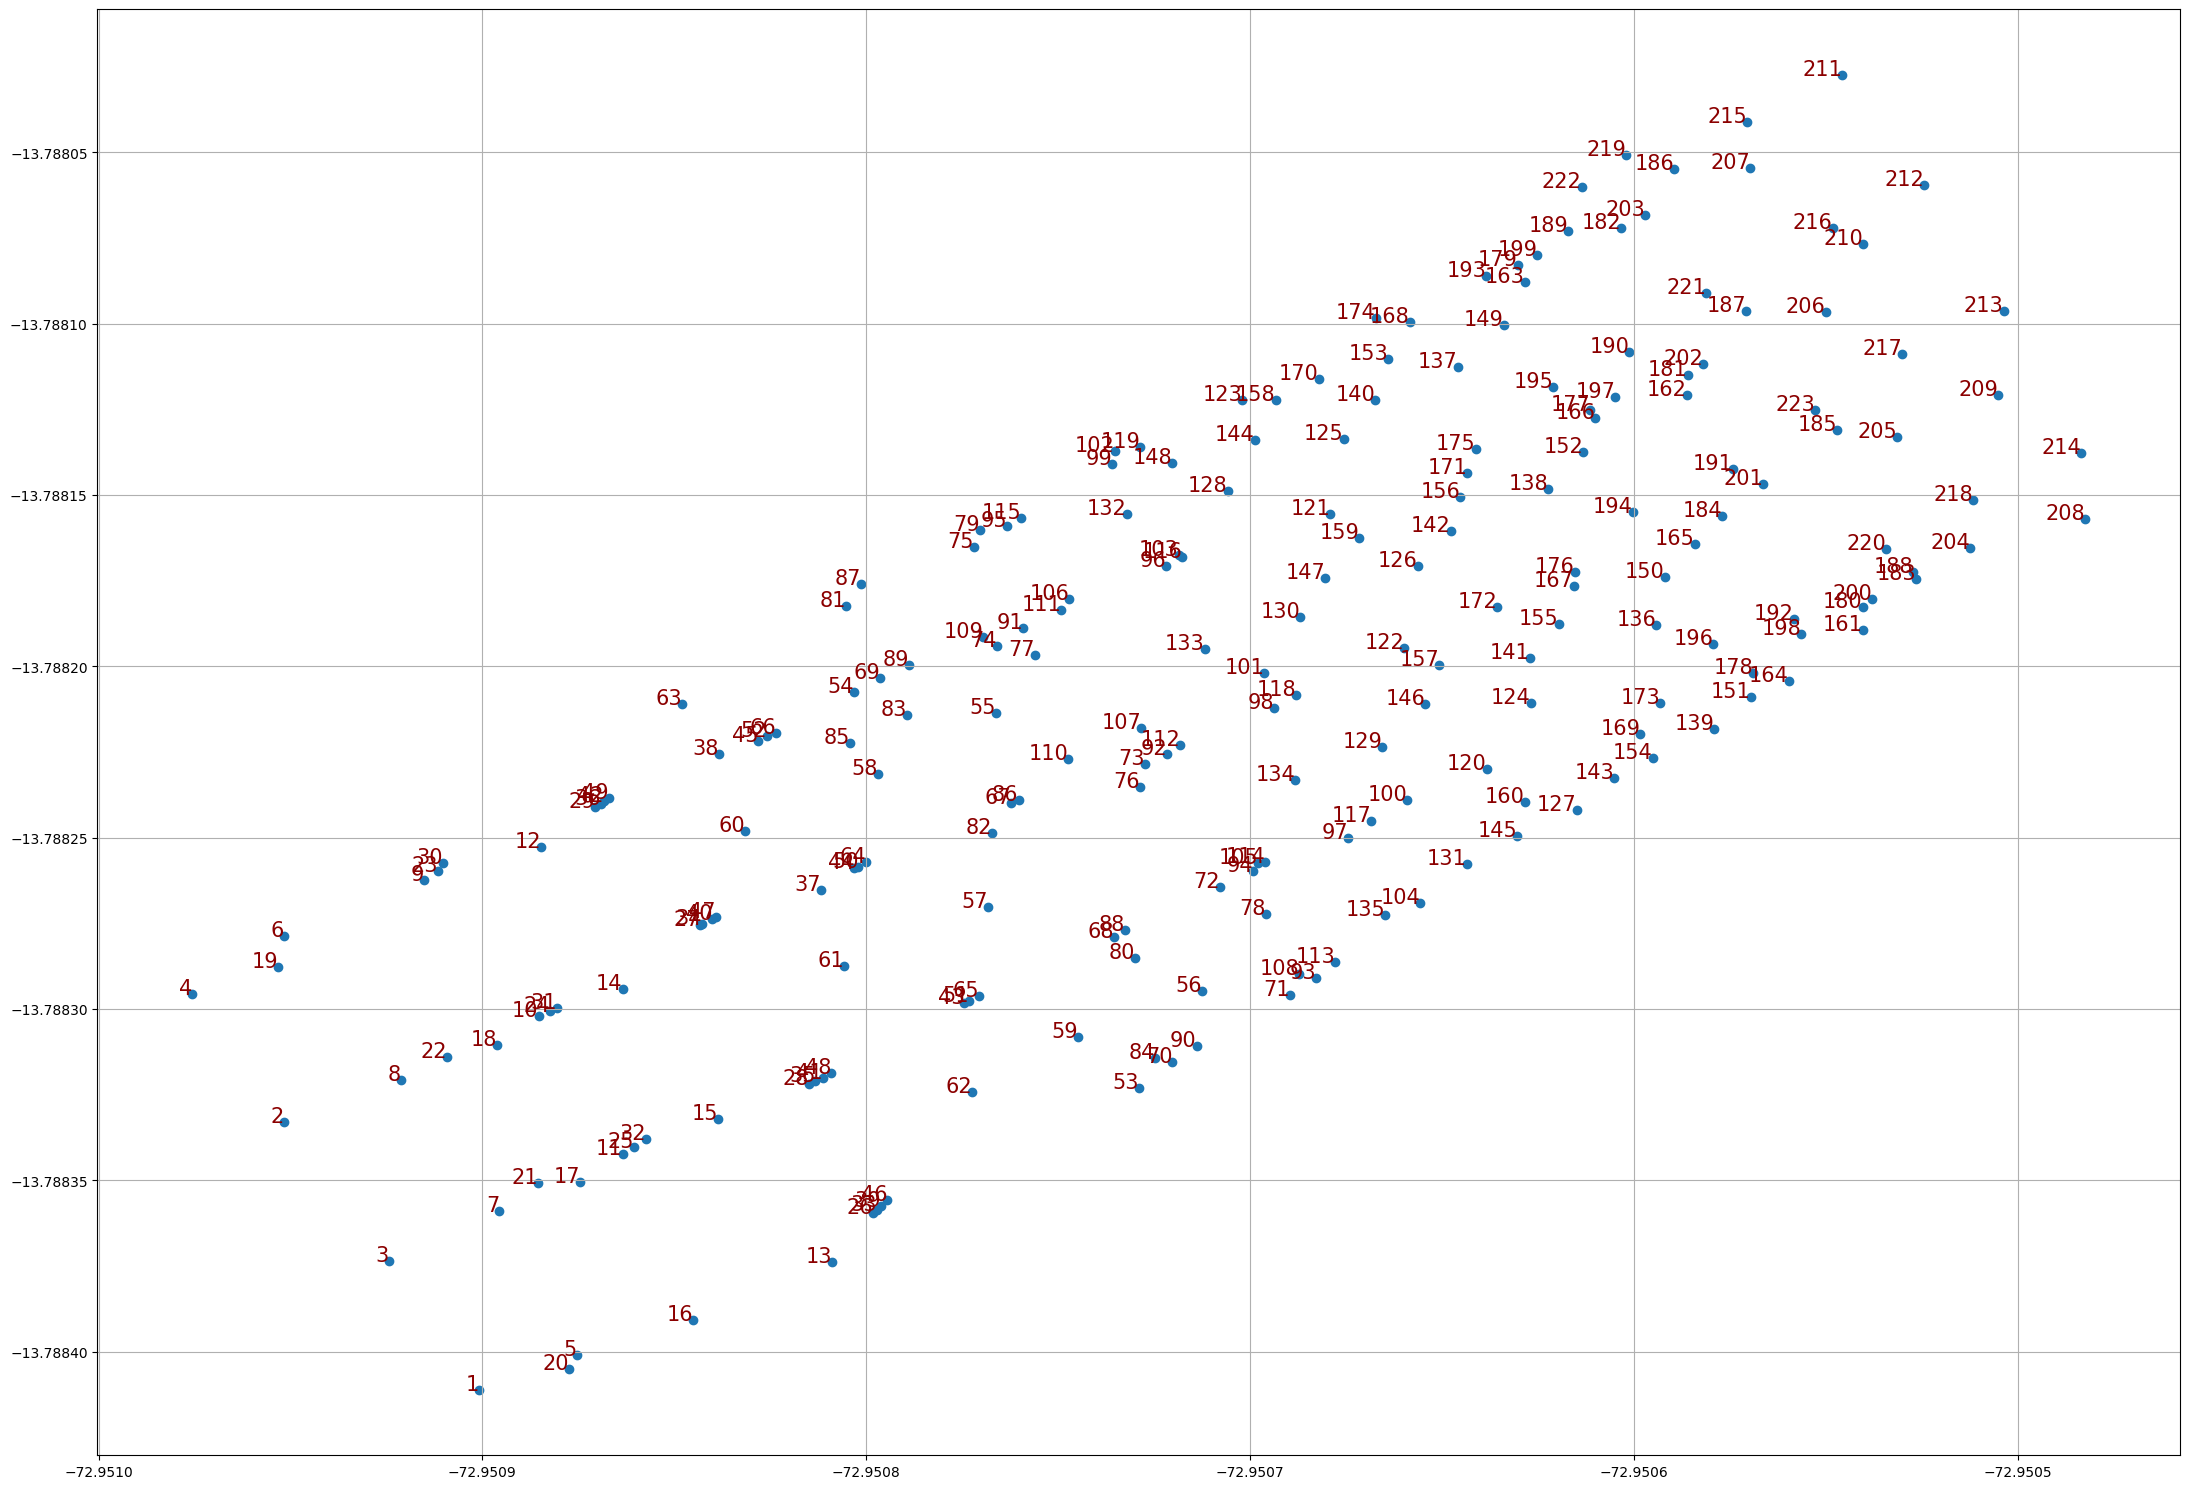

In [16]:
fig = plt.figure(figsize=(22, 15))
latitudes, longitudes = zip(*all_coordinates[:])
plt.scatter(longitudes , latitudes)
for i, (x, y) in enumerate(zip(longitudes, latitudes)):
    plt.text(x, y, str(i + 1), fontsize = 15, ha = "right", color = "darkred")
plt.ticklabel_format(useOffset=False, style='plain', axis='both')
plt.grid(True)
# Mostrar la figura completa
plt.tight_layout()
plt.show()

In [91]:
!pip install plotly

   ---------------------------------------- 0.0/19.1 MB ? eta -:--:--
    --------------------------------------- 0.3/19.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/19.1 MB 1.4 MB/s eta 0:00:14
   -- ------------------------------------- 1.0/19.1 MB 1.7 MB/s eta 0:00:11
   -- ------------------------------------- 1.3/19.1 MB 1.8 MB/s eta 0:00:11
   --- ------------------------------------ 1.8/19.1 MB 1.8 MB/s eta 0:00:10
   ---- ----------------------------------- 2.4/19.1 MB 1.9 MB/s eta 0:00:09
   ------ --------------------------------- 2.9/19.1 MB 2.0 MB/s eta 0:00:09
   ------ --------------------------------- 3.1/19.1 MB 2.0 MB/s eta 0:00:08
   ------- -------------------------------- 3.4/19.1 MB 2.0 MB/s eta 0:00:08
   -------- ------------------------------- 3.9/19.1 MB 2.0 MB/s eta 0:00:08
   --------- ------------------------------ 4.5/19.1 MB 2.0 MB/s eta 0:00:08
   ----------- ---------------------------- 5.2/19.1 MB 2.1 MB/s eta 0:00:07
   ----------